The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [6]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.2e-3

In [7]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [8]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [9]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [10]:
def load_exp_data(direc, cut=None, layer_size=25, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if reverse:
        file_names = [f for f in reversed(file_names)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            summed_incoming_weights = loaded['w_r_e_summed']
            summed_incoming_weights_e_i = loaded['w_r_e_i_summed']

            try:
                exc_cells_initially_active = loaded['exc_raster']
                exc_cells_newly_active = None
            except KeyError as e:
                exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
                exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
                exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
                if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                    exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
            inh_raster = loaded['inh_raster']

            try:
                surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
            except KeyError as e:
                surviving_cell_indices = np.ones(summed_incoming_weights.shape[0], dtype=bool)

            summed_incoming_weights = summed_incoming_weights[(surviving_cell_indices).nonzero()[0]]

            first_spk_times = process_single_activation(exc_cells_initially_active, 4000)

            num_layers_active = 0
            layer_weights = []

            for i in range(0, len(first_spk_times), layer_size):
                layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
                if layer_active:
                    num_layers_active += 1

                layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
                layer_weights.append(layer_weight)

            data = {
                'index': i_f,
                'percent_layers_active': num_layers_active / (len(first_spk_times) / layer_size),
                'first_spk_times': first_spk_times,
                
                'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
                'median_incoming_summed_weights': np.median(summed_incoming_weights),
                'std_incoming_summed_weights': np.std(summed_incoming_weights),
                'summed_incoming_weights': summed_incoming_weights,
                
                'mean_incoming_summed_weights_e_i': np.mean(summed_incoming_weights_e_i),
                'median_incoming_summed_weights_e_i': np.median(summed_incoming_weights_e_i),
                'std_incoming_summed_weights_e_i': np.std(summed_incoming_weights_e_i),
                'summed_incoming_weights_e_i': summed_incoming_weights_e_i,
                
                'exc_cells_initially_active': exc_cells_initially_active,
                'exc_cells_newly_active': exc_cells_newly_active,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                'surviving_cell_indices': surviving_cell_indices,
            }
            return data
        yield i_f, lazy_load

In [11]:
def make_figure_1(name, timepoints = [0, 72, 73], verify_chain_timepoints=None):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    if verify_chain_timepoints is None:
        verify_chain_timepoints = np.arange(10)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
#         print(exp_dir_name)
        scale = 1.1
        
        timepoints_verified = np.zeros(len(verify_chain_timepoints))
        
        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
            if i in verify_chain_timepoints:
                data = load_data()
                timepoints_verified[i] = int(data['percent_layers_active'] >= 0.9)
        if (np.sum(timepoints_verified) / len(timepoints_verified)) < 1.:
            continue
           
        fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12 * scale, 4 * scale))
        timepoint_names = [rendition_label(t * 10) for t in timepoints]
        j = 0
        
        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):                
            if j < len(timepoints) and i == timepoints[j]:
                data = load_data()
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                inh_raster = data['inh_raster']

                if j == 0:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                else:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                    if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0:
                        axs[j].scatter(exc_cells_newly_active[0, :] * 1000, exc_cells_newly_active[1, :], s=1, c='green', zorder=1, alpha=1)

                if len(inh_raster) > 0:
                    axs[j].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='blue', zorder=0, alpha=1)
                axs[j].set_ylim(150, 4450)
                axs[j].set_xlim(.050 * 1000, 0.500 * 1000)
                axs[j].set_ylabel('Cell Index')
                axs[j].set_xlabel('Time (ms)')
                axs[j].title.set_text(f'{timepoint_names[j]}')
                set_font_size(axs[j], 16)
                j += 1
        
        fig.tight_layout()  
        save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')
        

In [12]:
title_one_sided_large_gamma_small_inh = ['pop_single_one_sided__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.005_ALPHA_1_0.03_GAMMA_3e-05_ff_1.0_eir_1.0_ier_0.3']
title_one_sided_small_gamma_small_inh = ['pop_single_one_sided__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.005_ALPHA_1_0.03_GAMMA_1e-05_ff_1.0_eir_1.0_ier_0.3']
title_one_sided_large_gamma_large_inh = ['pop_single_one_sided__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.0075_ALPHA_1_0.03_GAMMA_3e-05_ff_1.0_eir_1.0_ier_0.3']
title_one_sided_small_gamma_large_inh = ['pop_single_one_sided__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.0075_ALPHA_1_0.03_GAMMA_1e-05_ff_1.0_eir_1.0_ier_0.3']
title_pop_single_small_inh = ['pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.005_ALPHA_1_0.03_GAMMA_1e-05_ff_1.0_eir_1.0_ier_0.3']
title_pop_single_large_inh = ['pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.0075_ALPHA_1_0.03_GAMMA_1e-05_ff_1.0_eir_1.0_ier_0.3']
title_wide_attr_small_inh = ['single_silent_only_wide_attr__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.005_ALPHA_1_0.03_ff_1.0_eir_1.0_ier_0.3']
title_wide_attr_large_inh = ['single_silent_only_wide_attr__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.0075_ALPHA_1_0.03_ff_1.0_eir_1.0_ier_0.3']
title_single_small_inh = ['single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.005_ALPHA_1_0.03_ff_1.0_eir_1.0_ier_0.3']
title_single_large_inh = ['single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_', '_ALPHA_2_0.0075_ALPHA_1_0.03_ff_1.0_eir_1.0_ier_0.3']



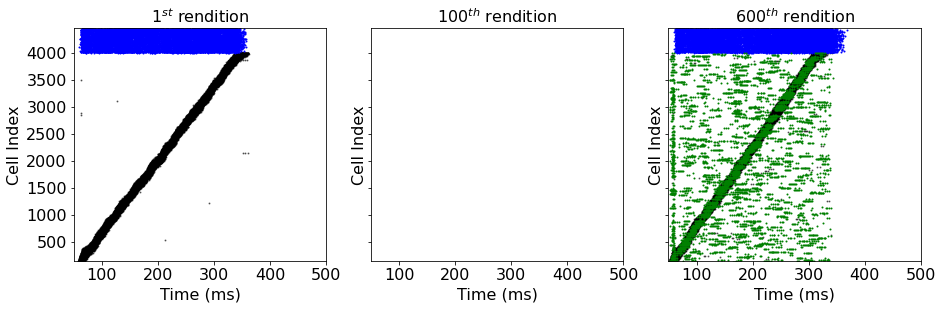

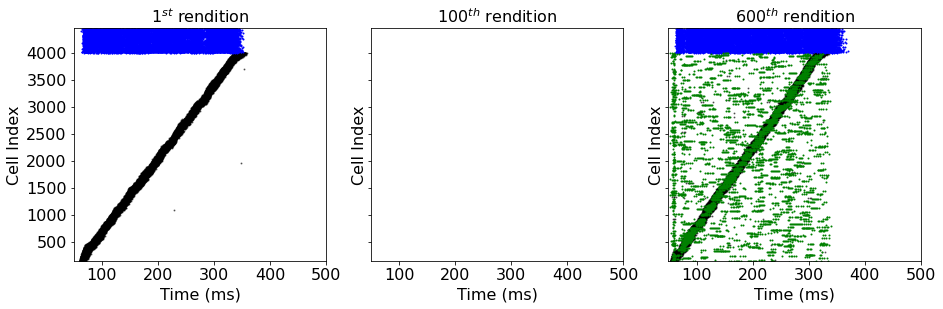

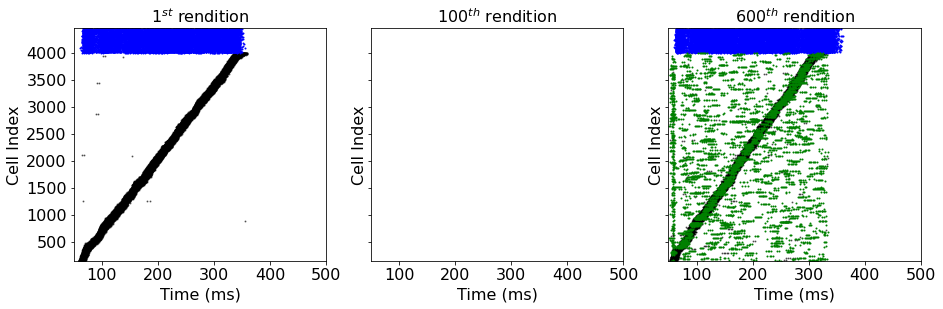

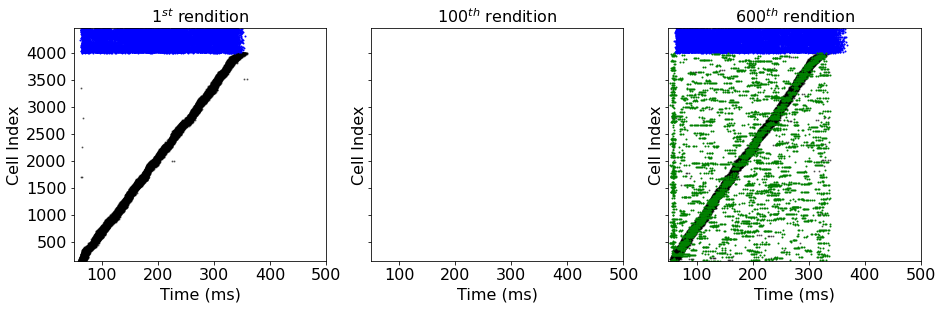

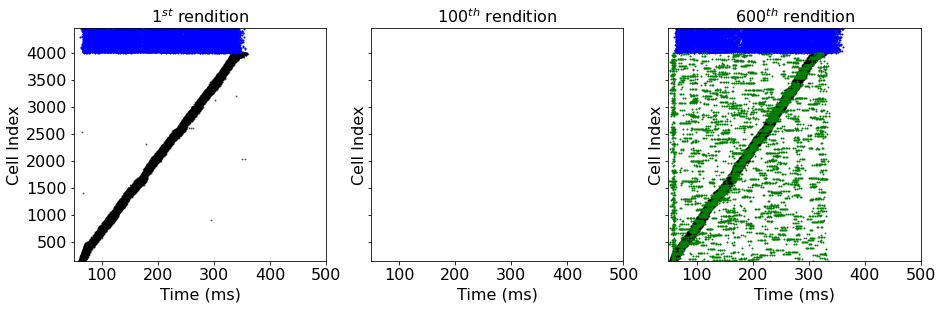

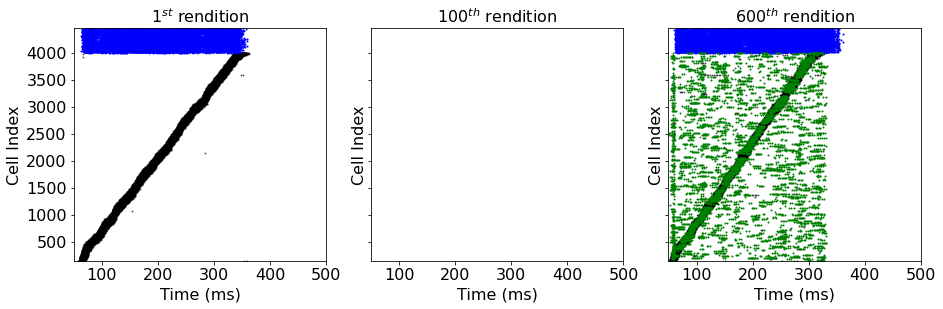

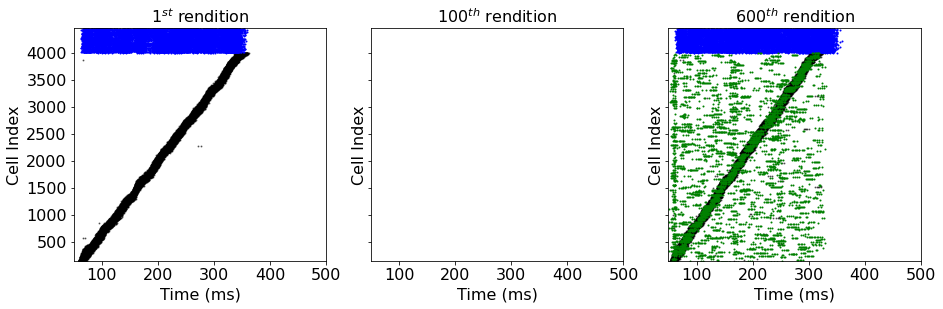

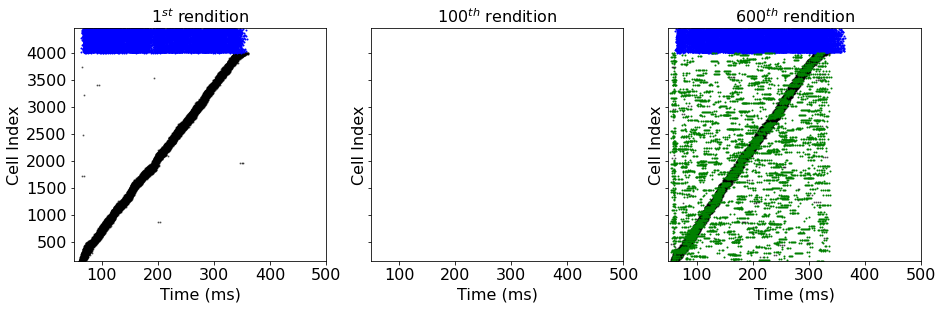

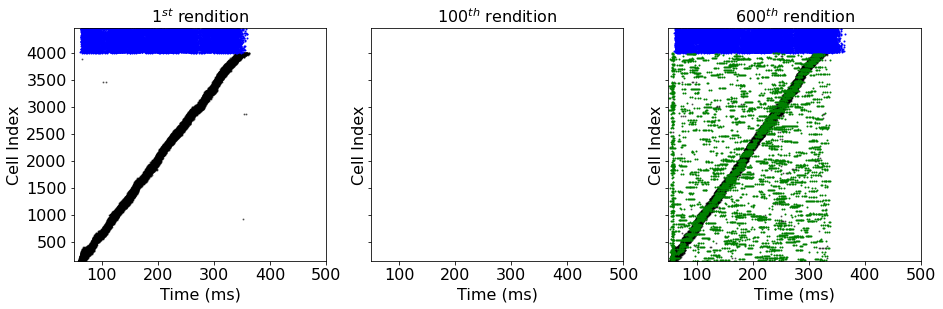

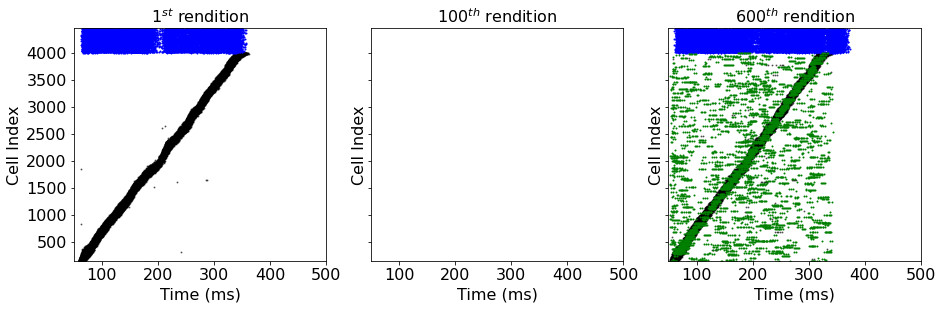

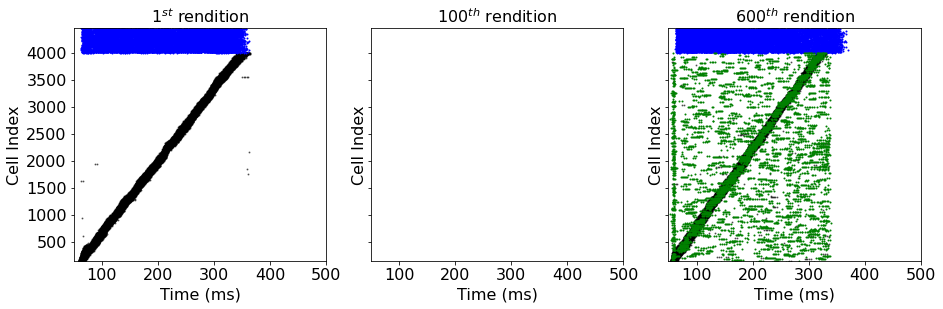

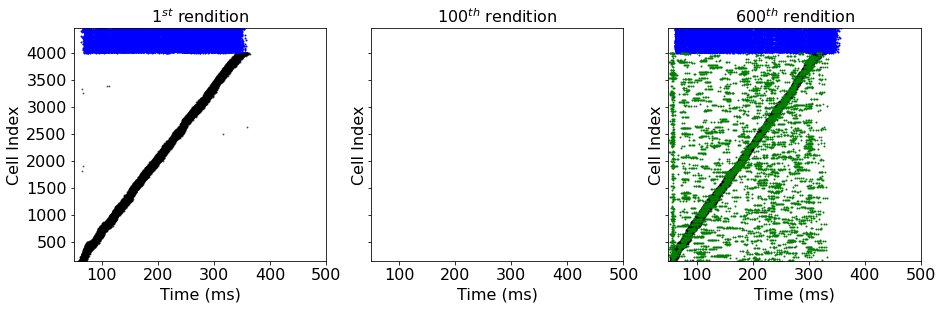

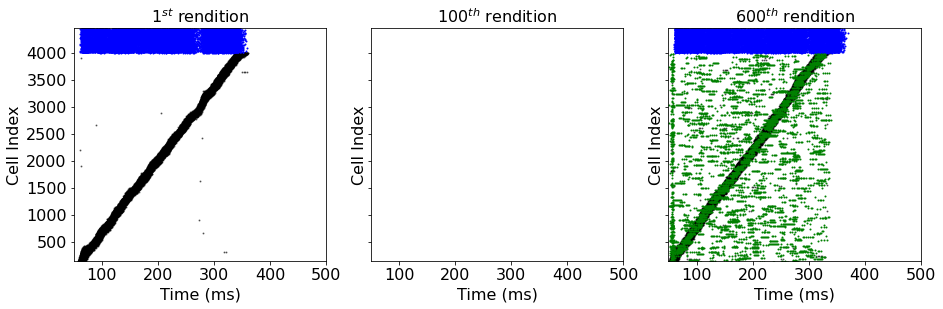

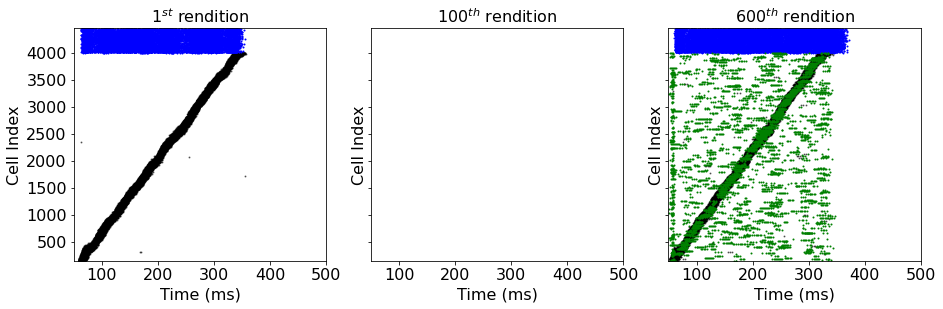

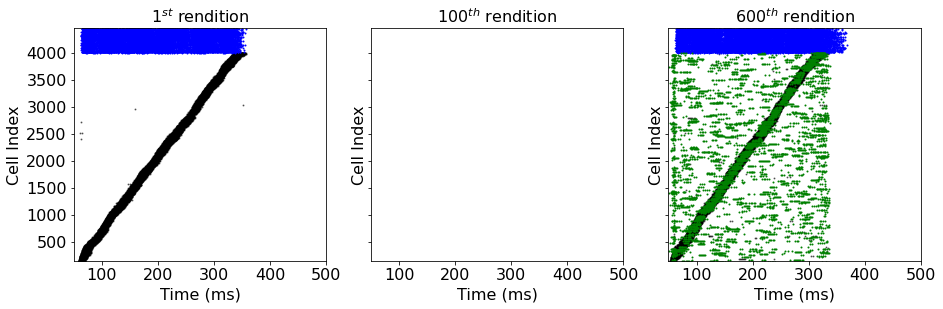

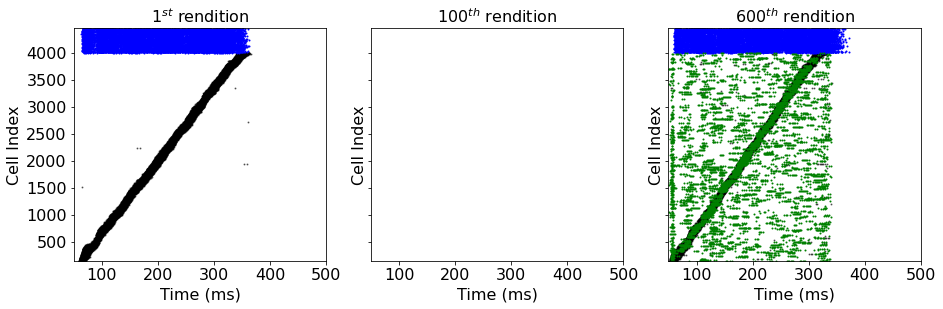

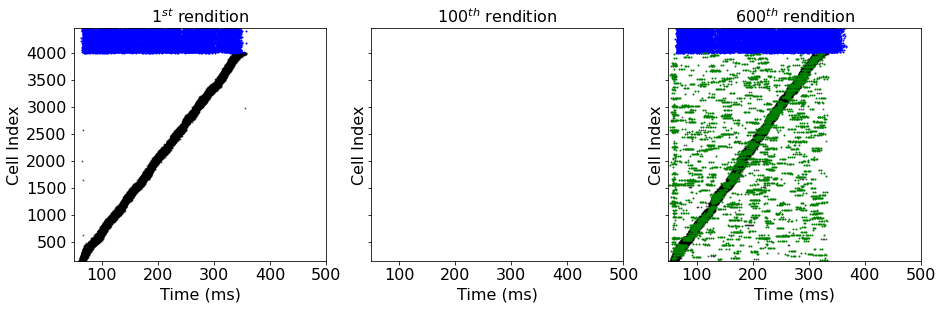

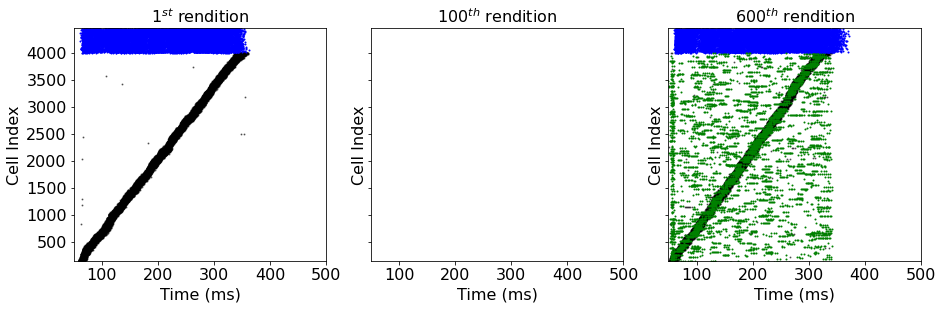

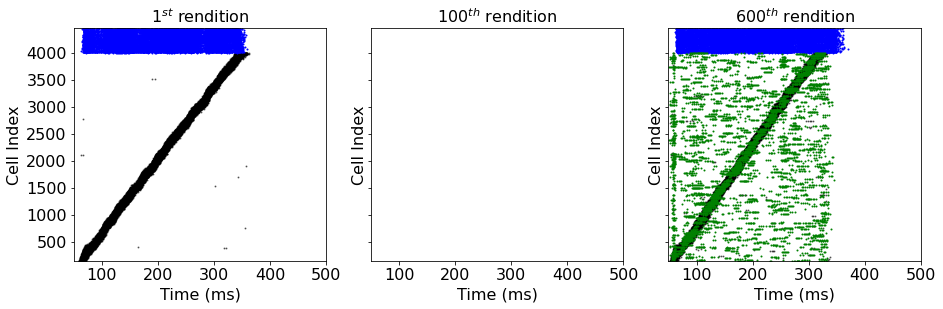

In [13]:
make_figure_1(title_one_sided_large_gamma_small_inh, timepoints = [0, 10, 60])

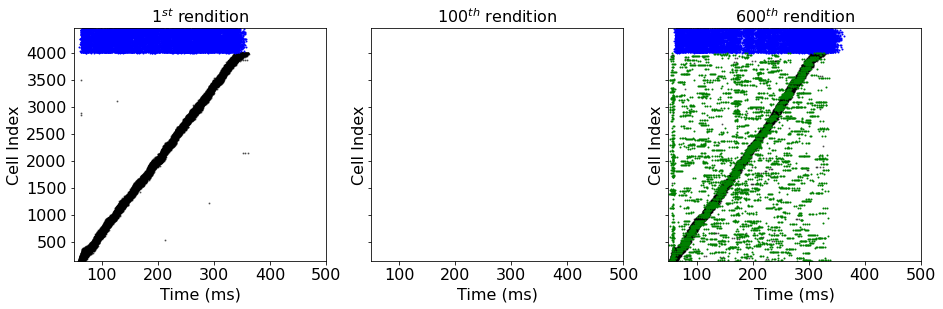

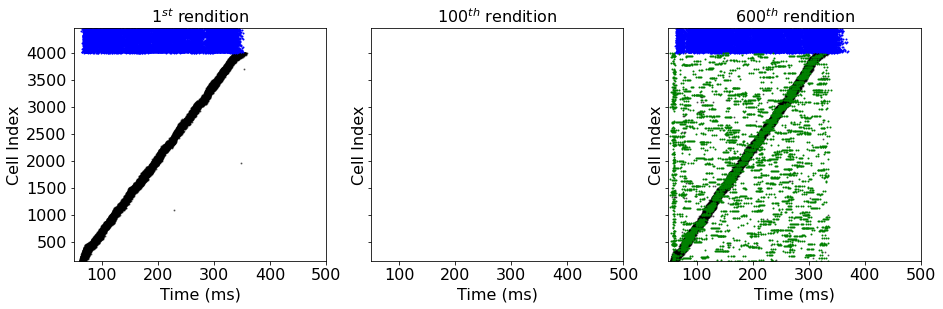

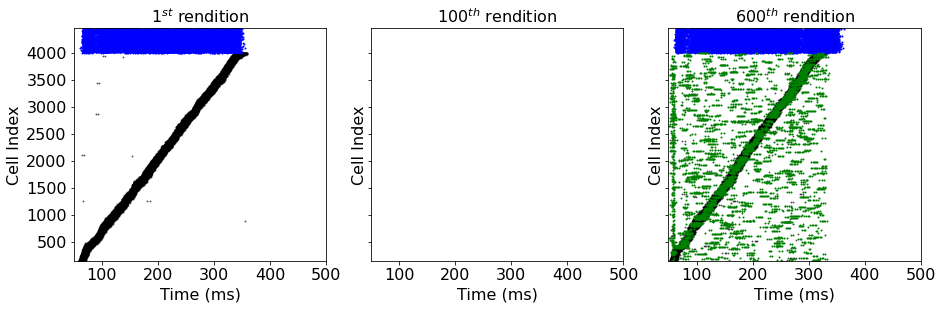

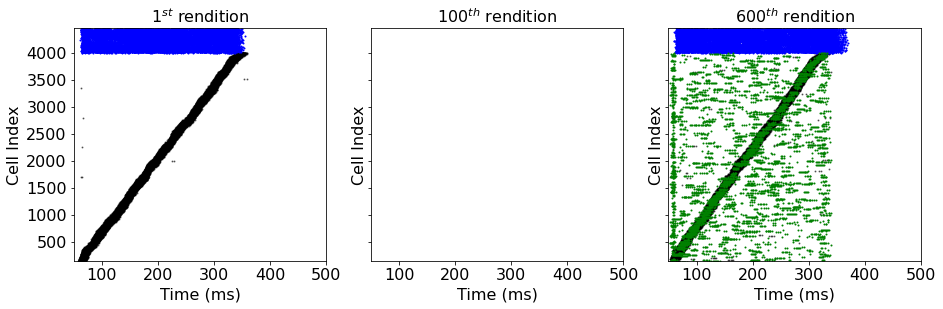

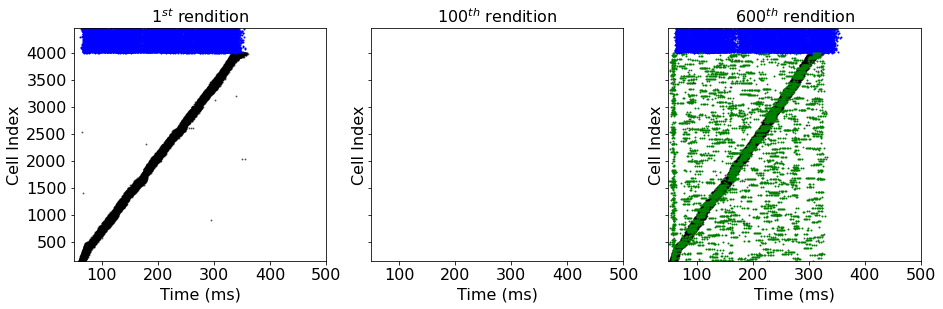

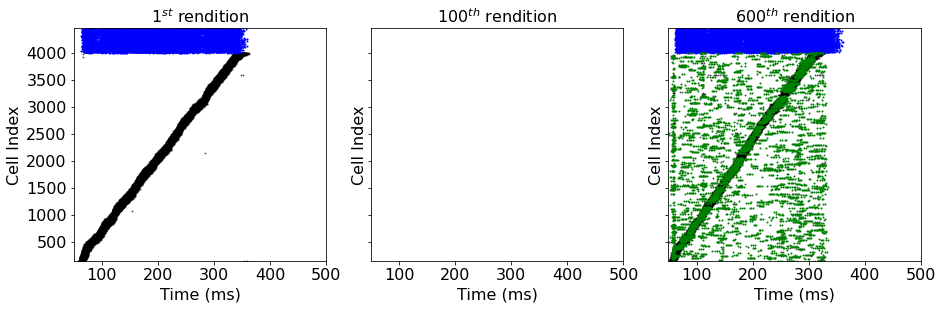

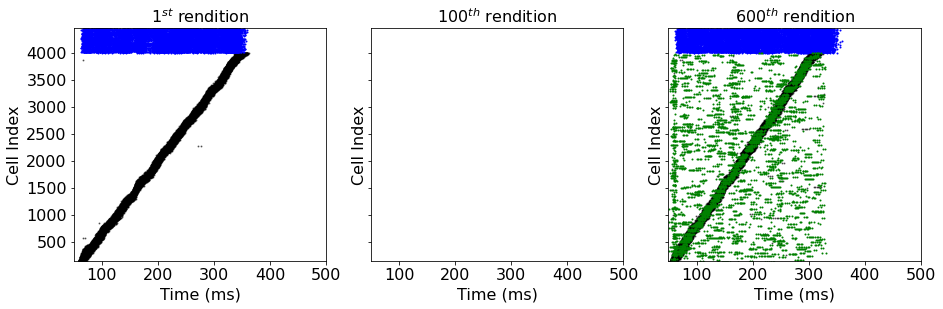

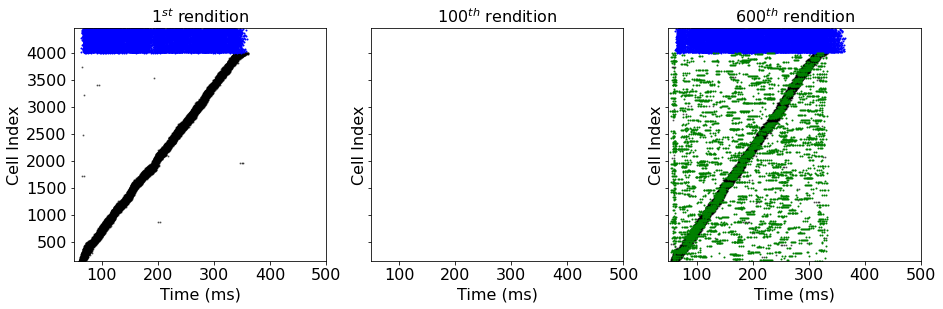

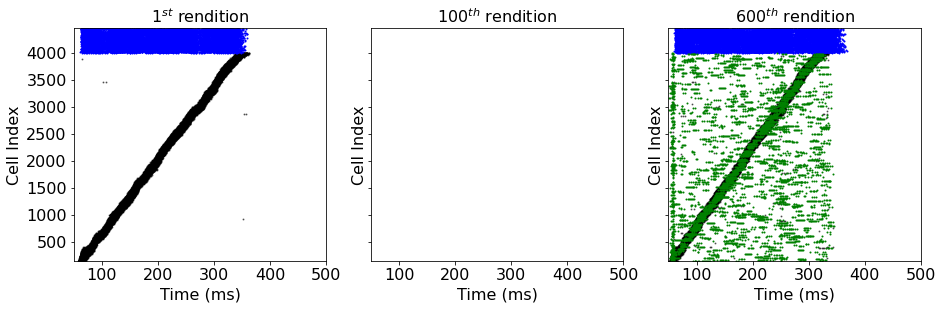

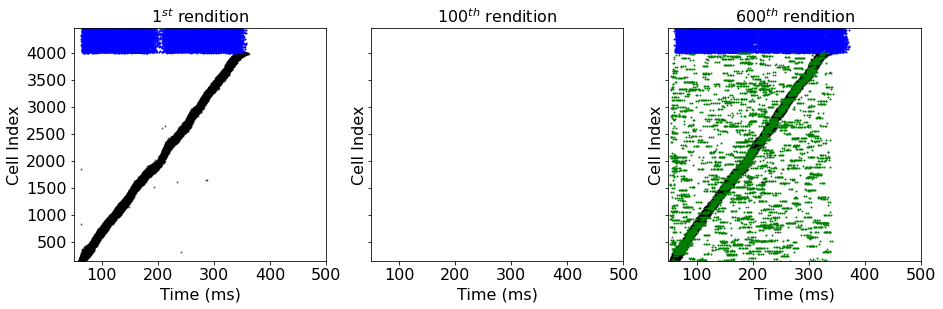

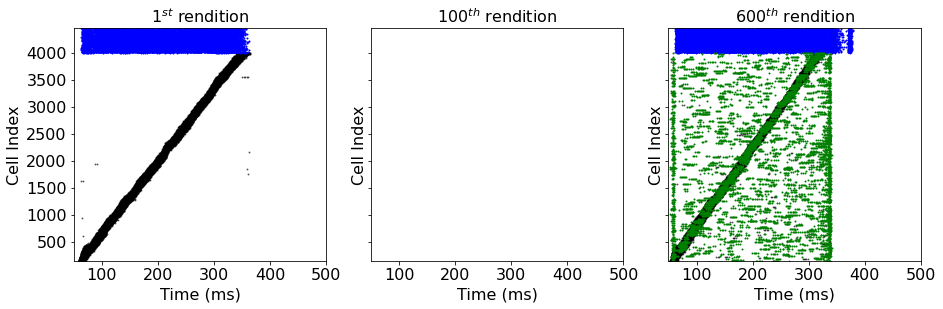

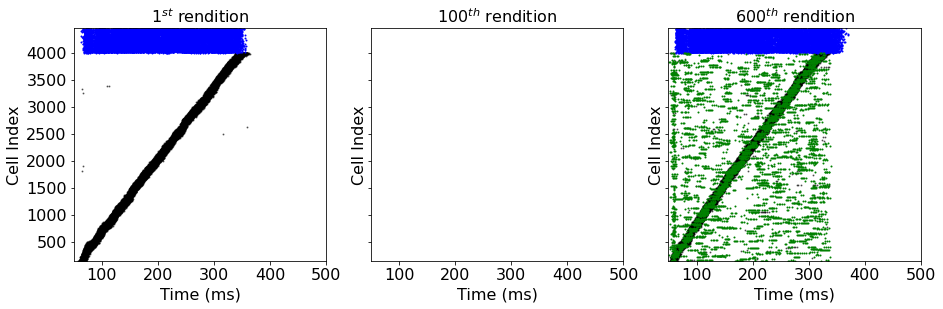

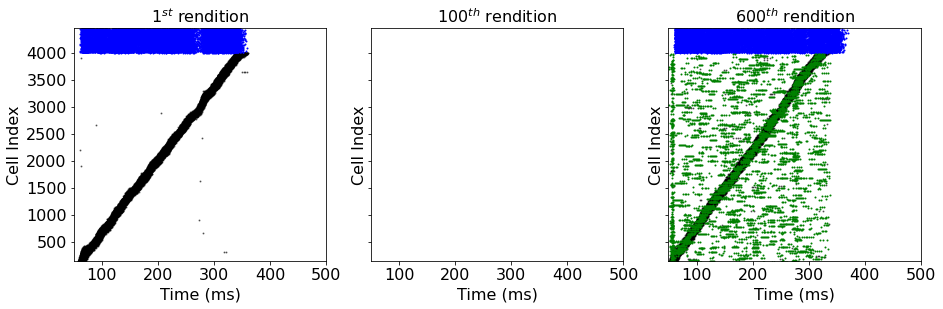

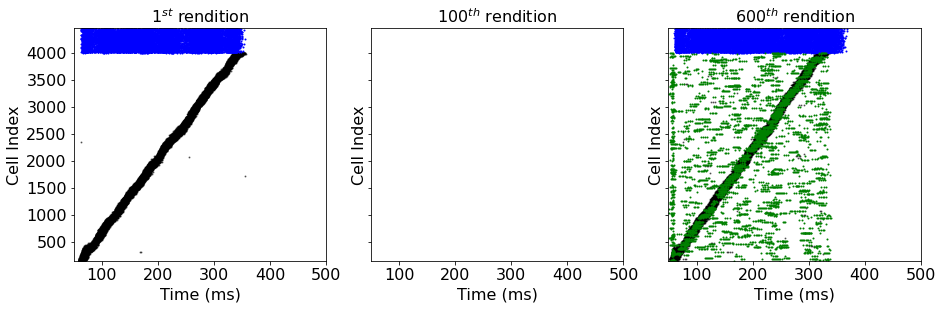

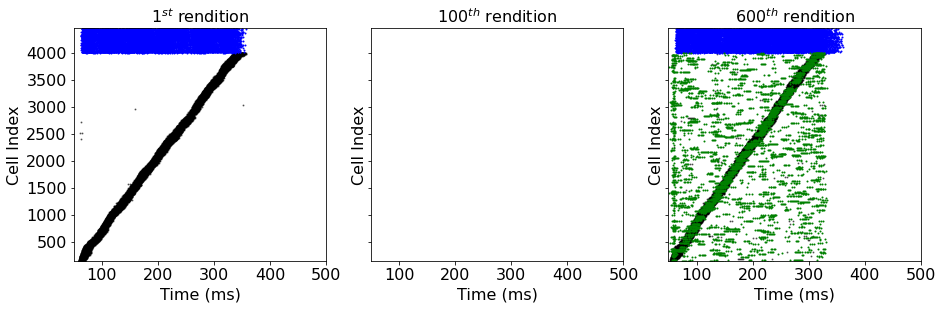

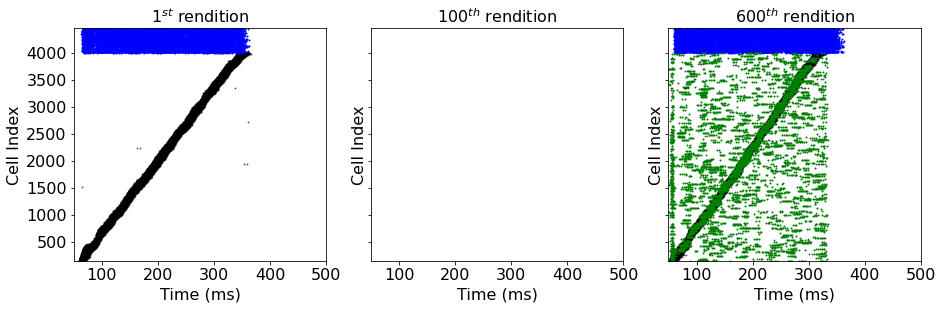

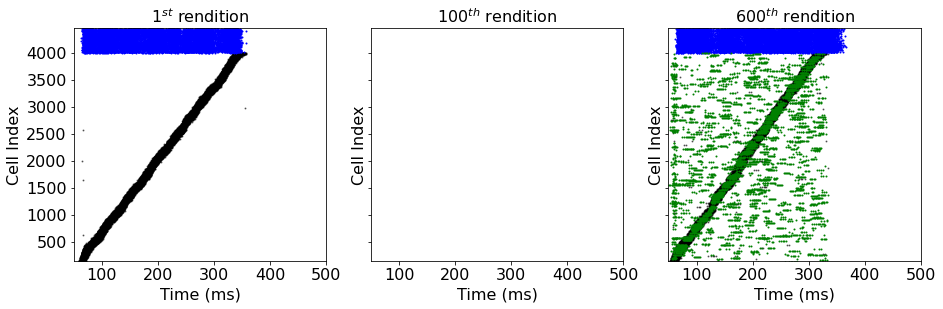

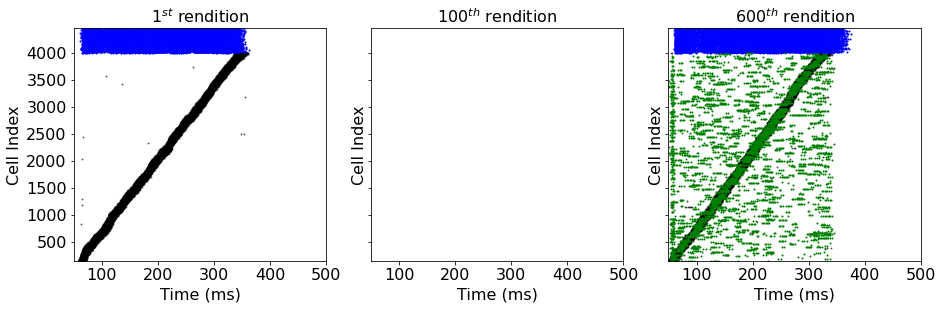

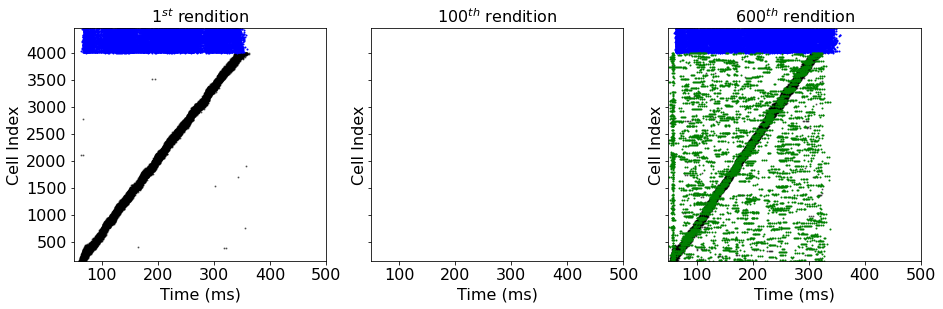

In [14]:
make_figure_1(title_one_sided_small_gamma_small_inh, timepoints = [0, 10, 60])

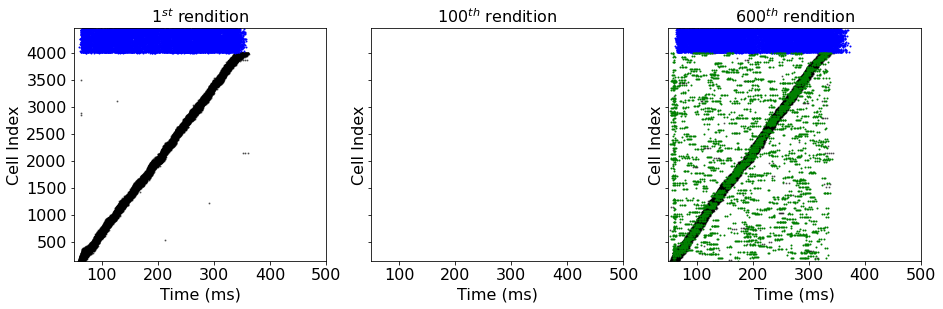

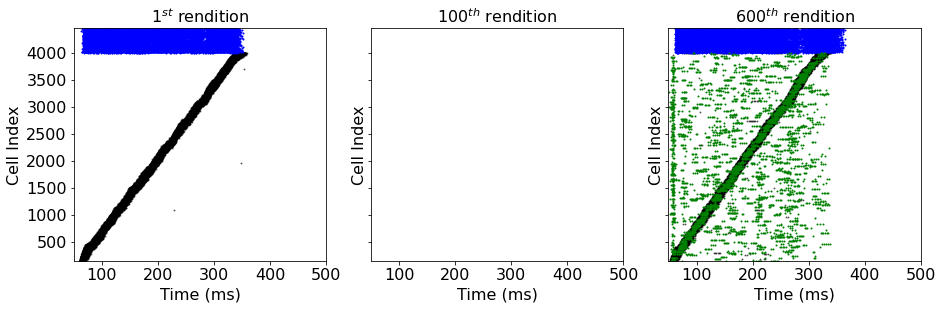

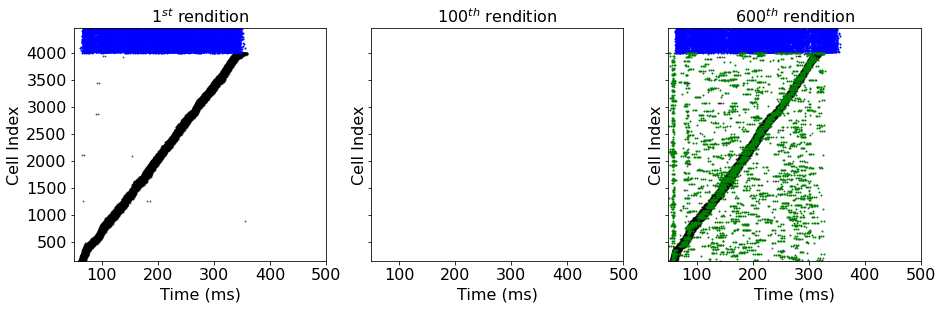

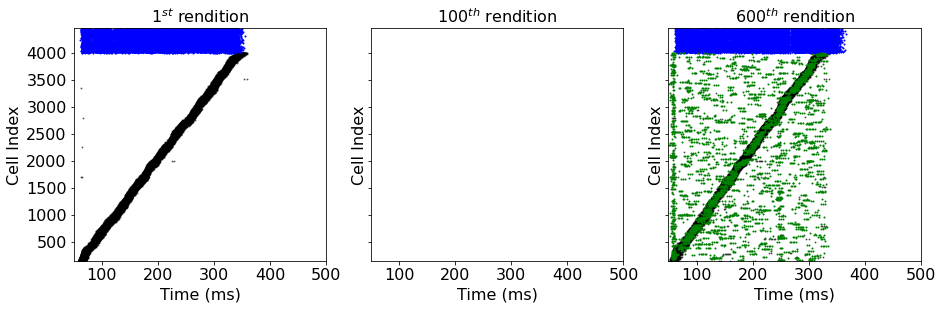

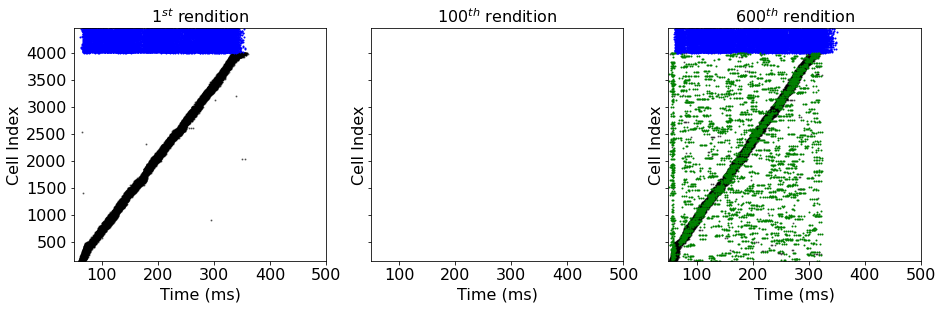

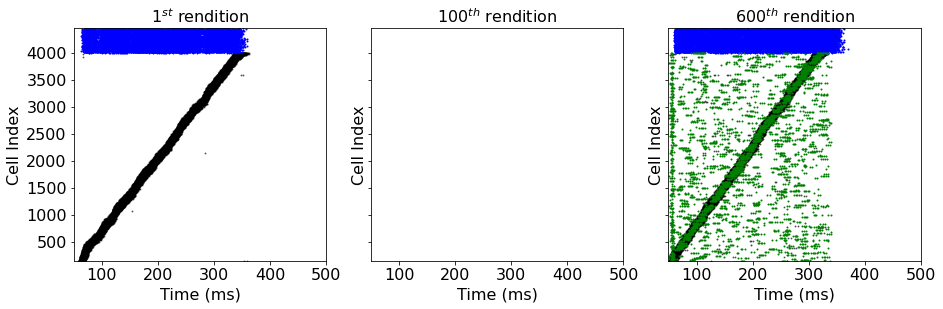

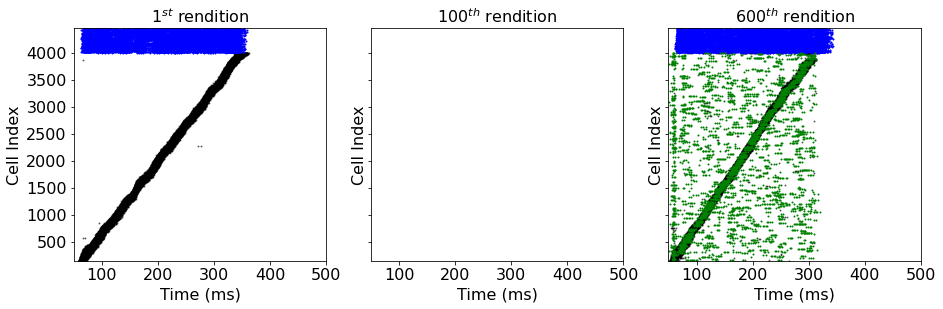

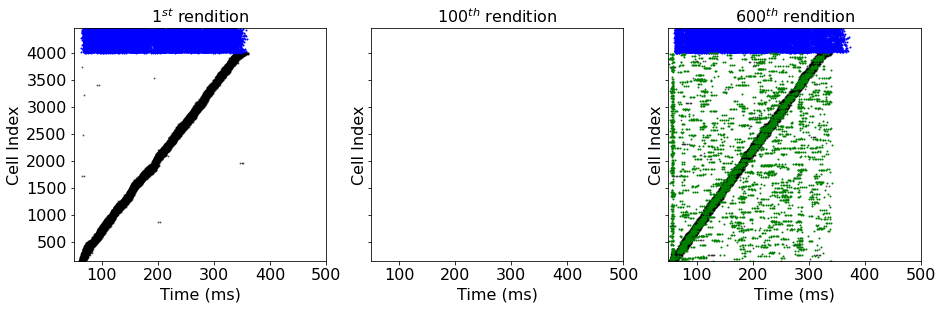

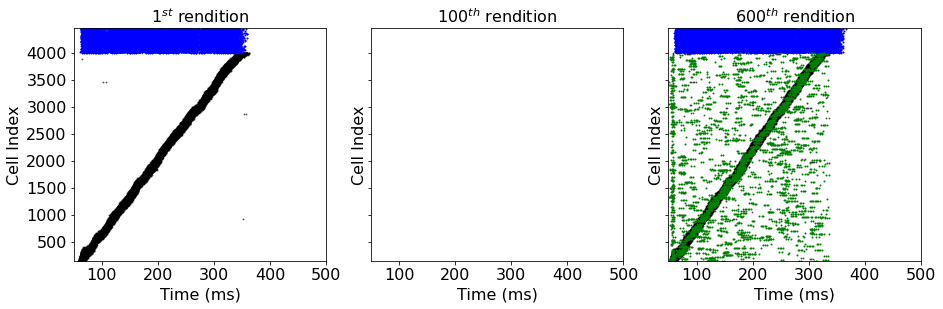

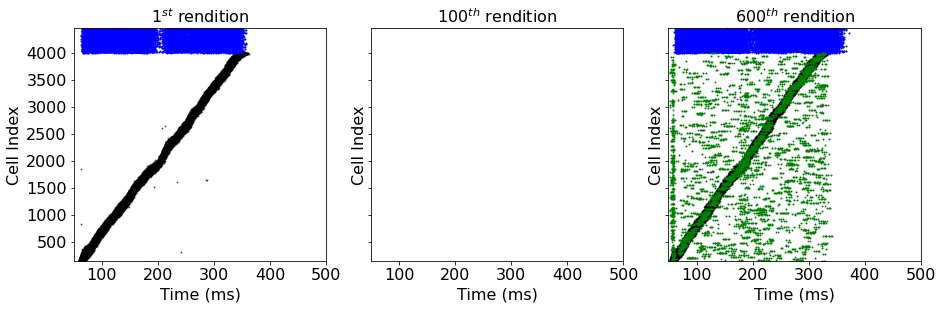

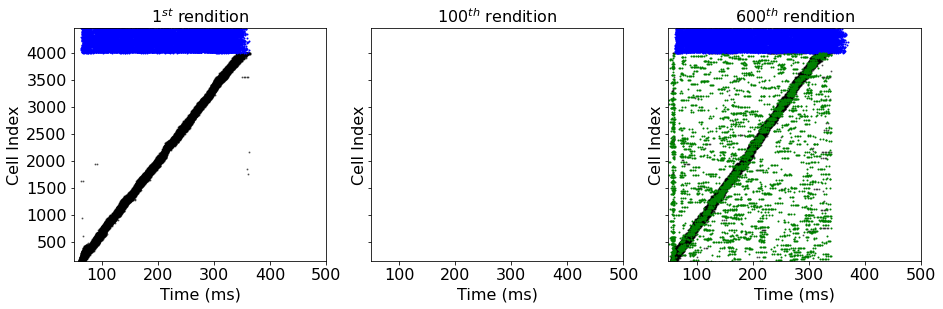

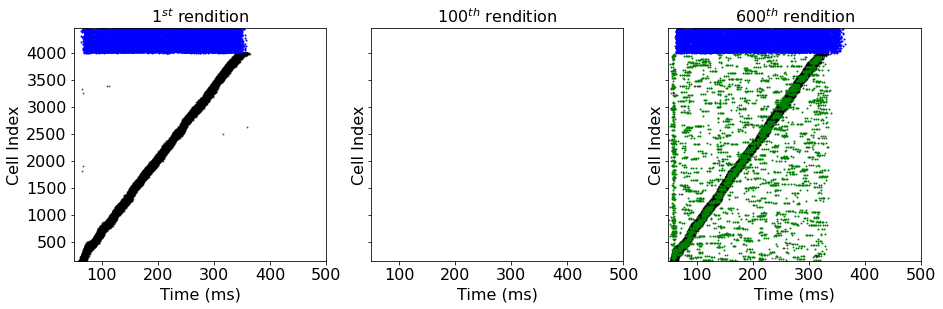

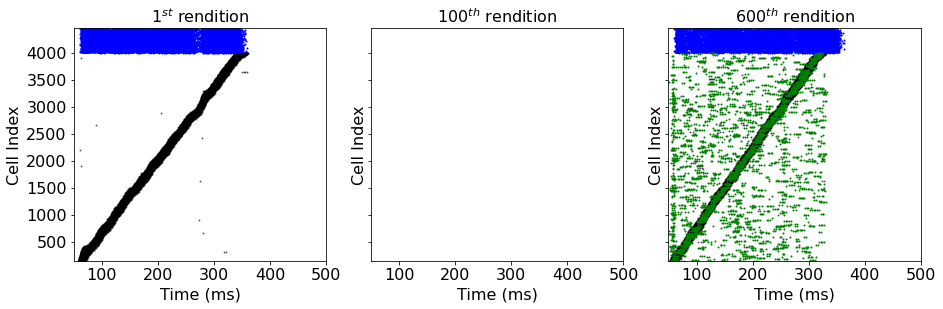

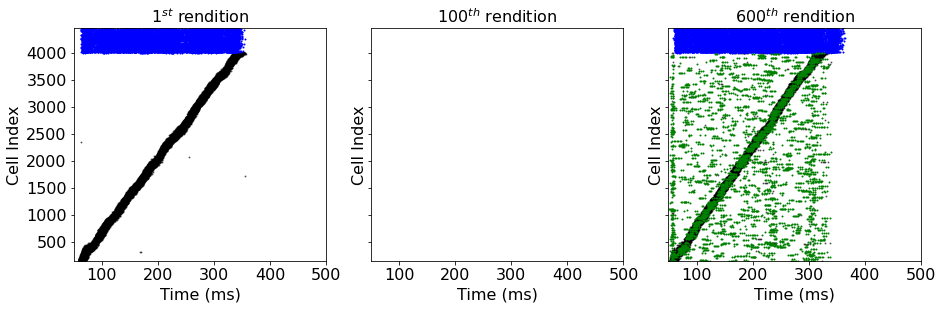

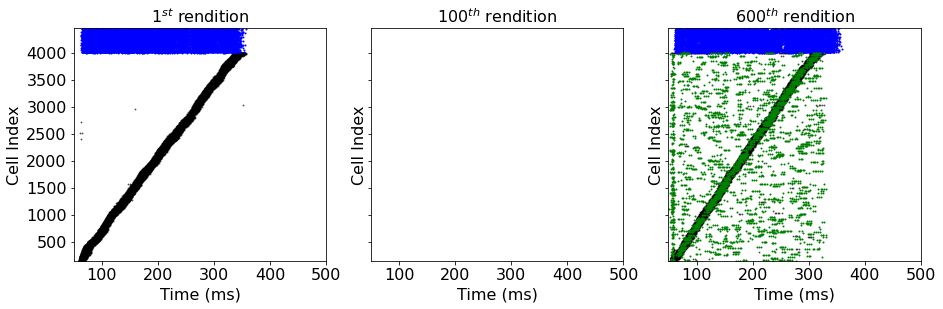

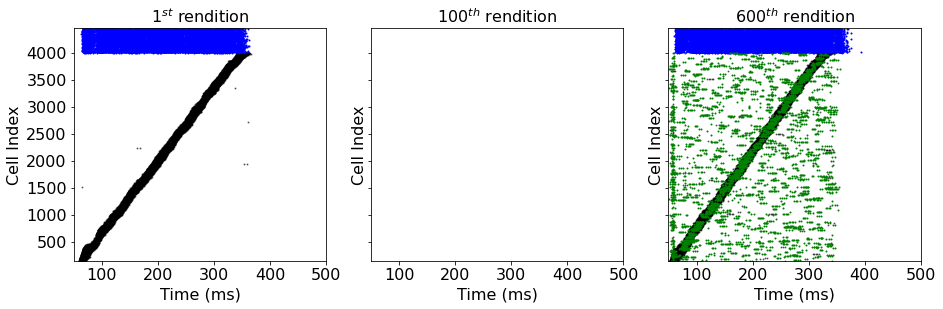

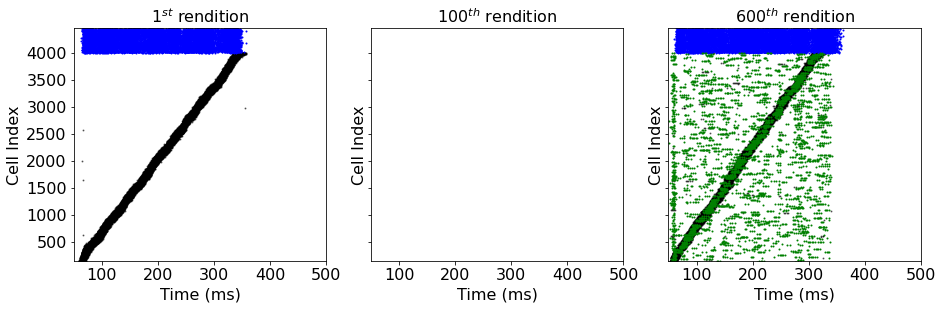

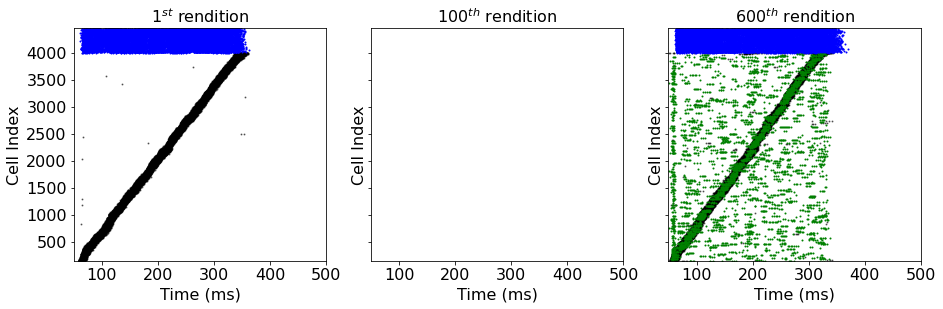

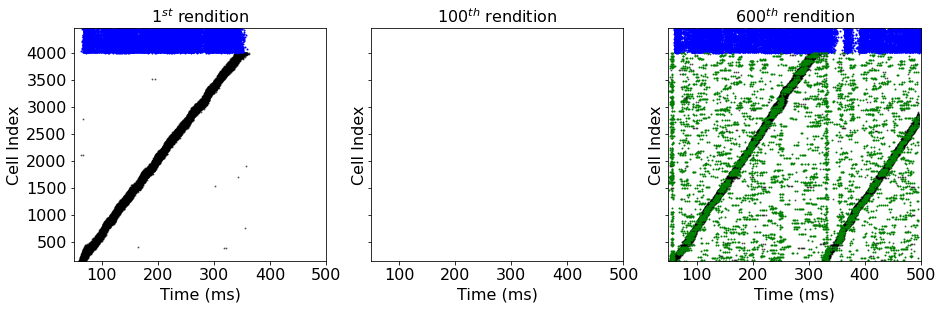

In [15]:
make_figure_1(title_pop_single_small_inh, timepoints = [0, 10, 60])

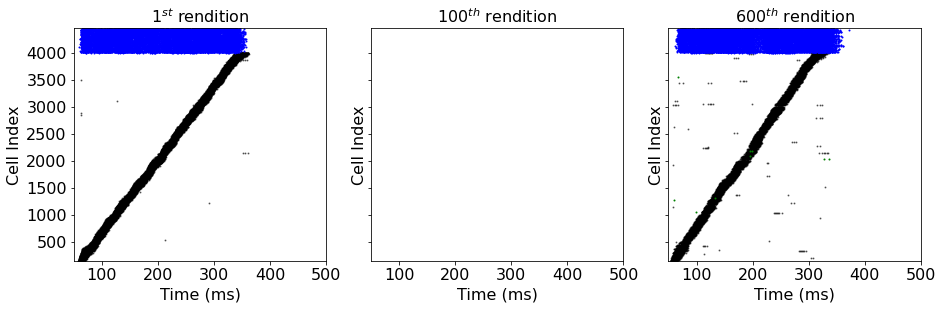

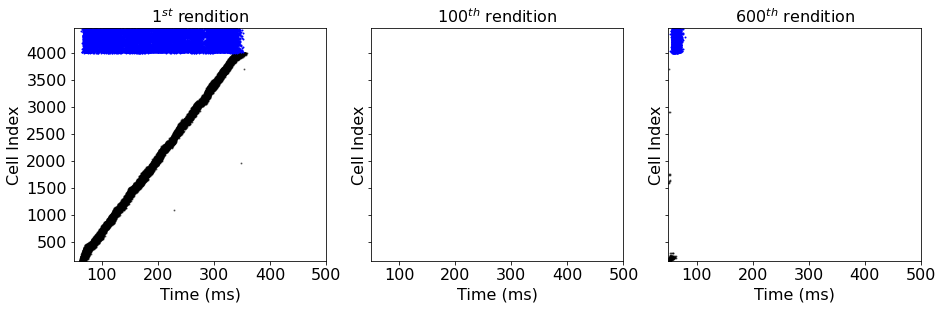

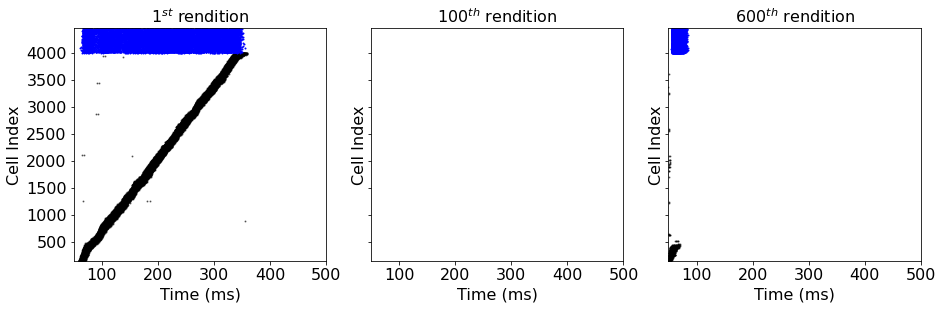

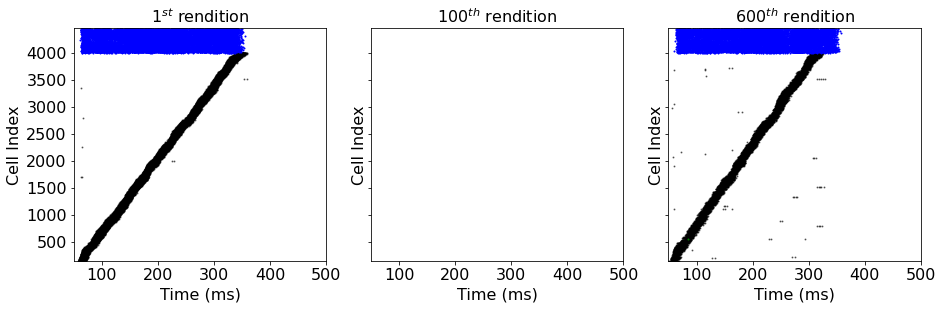

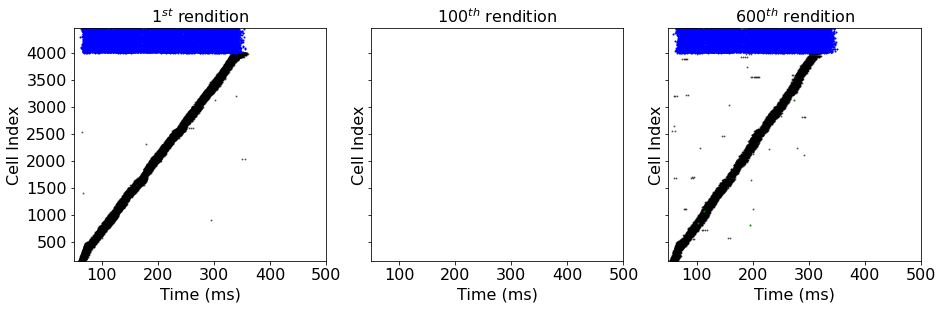

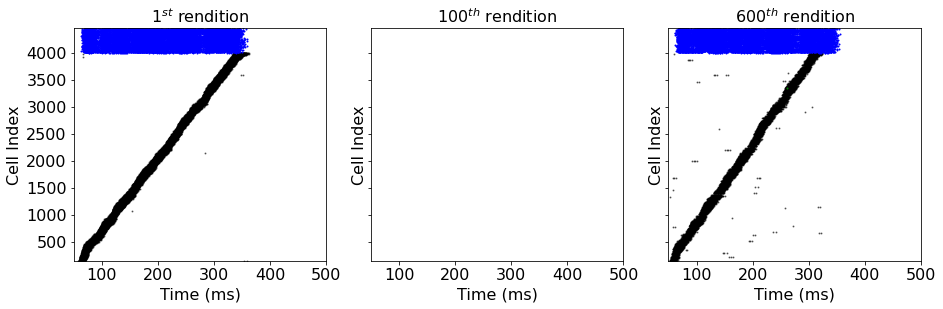

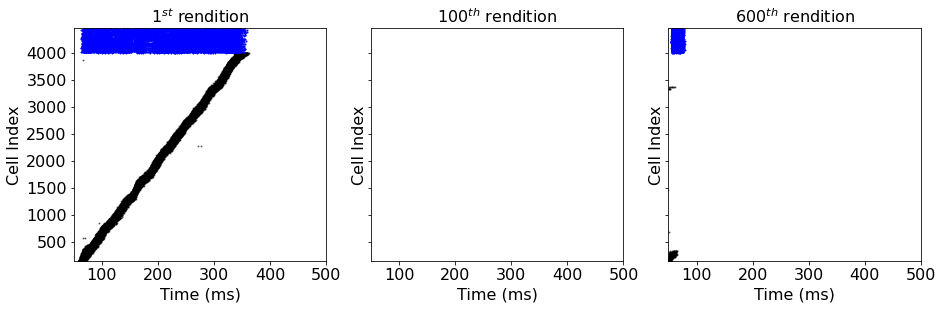

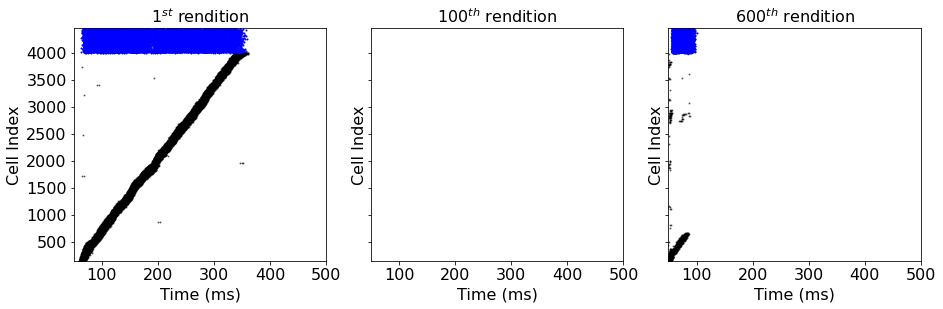

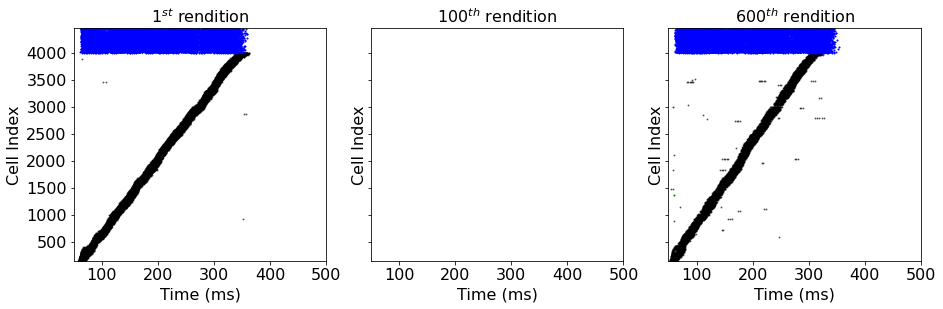

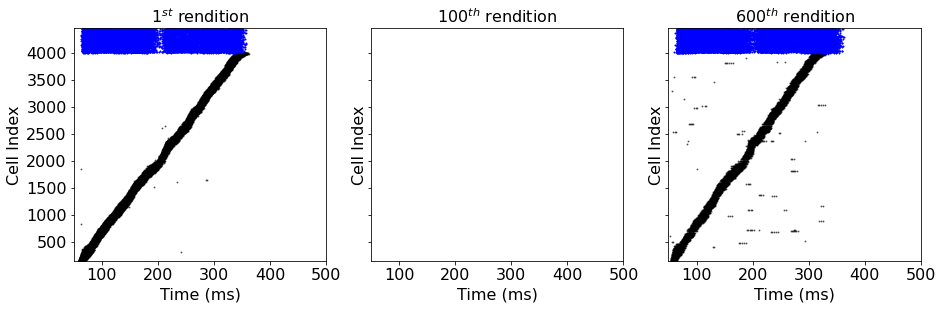

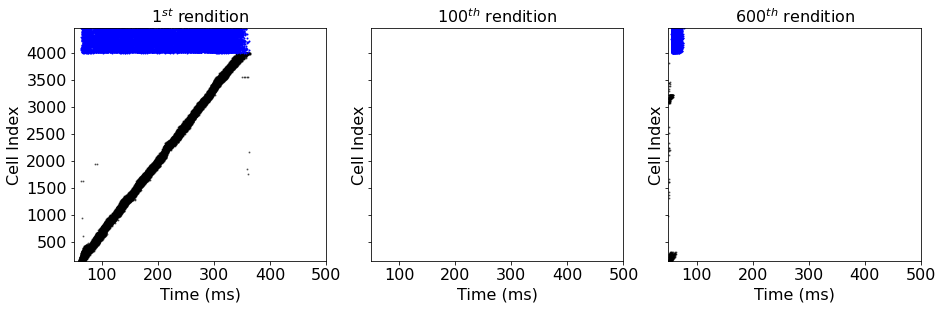

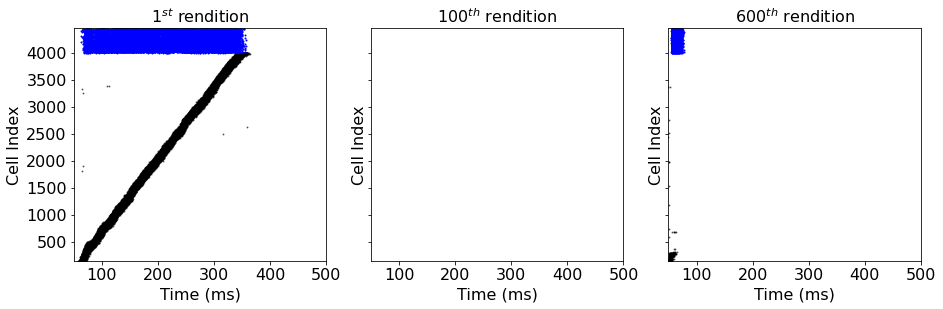

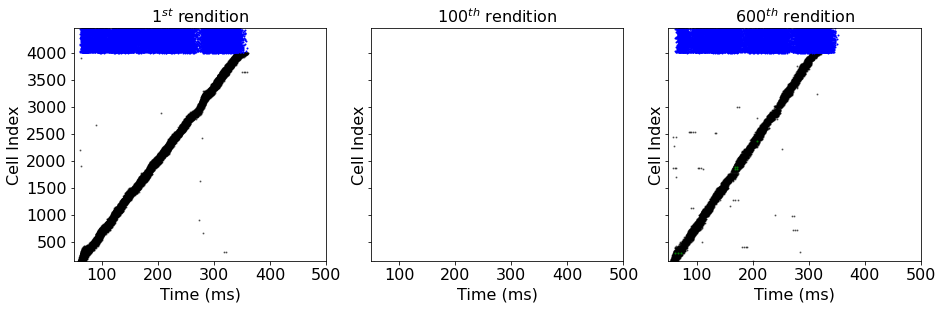

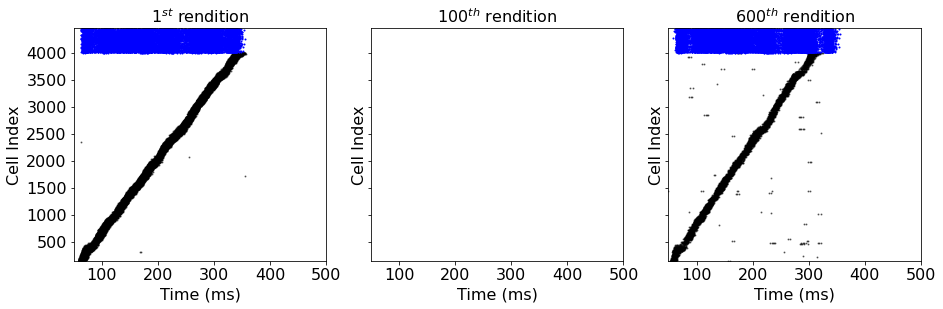

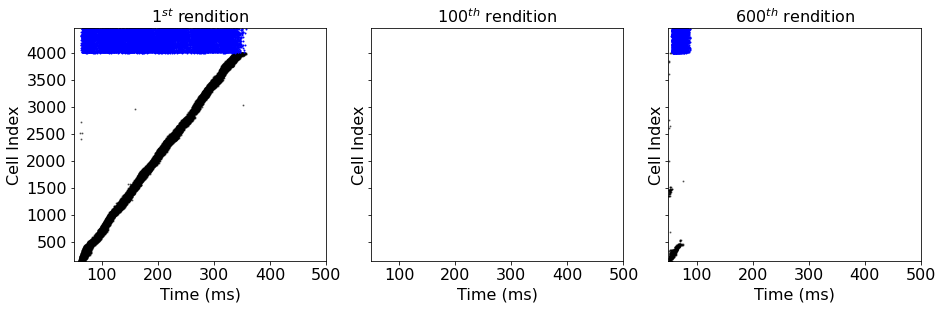

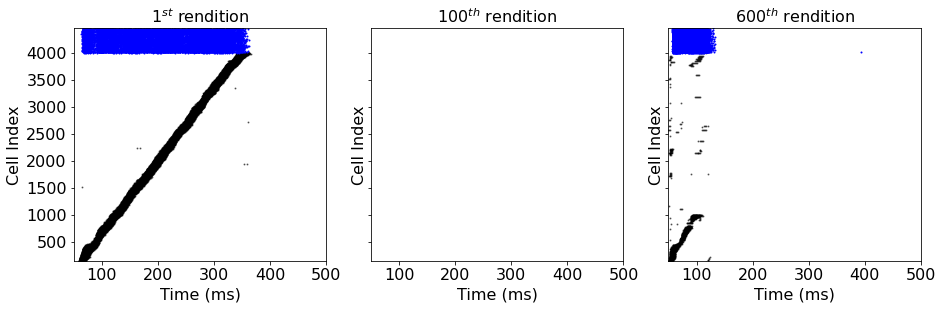

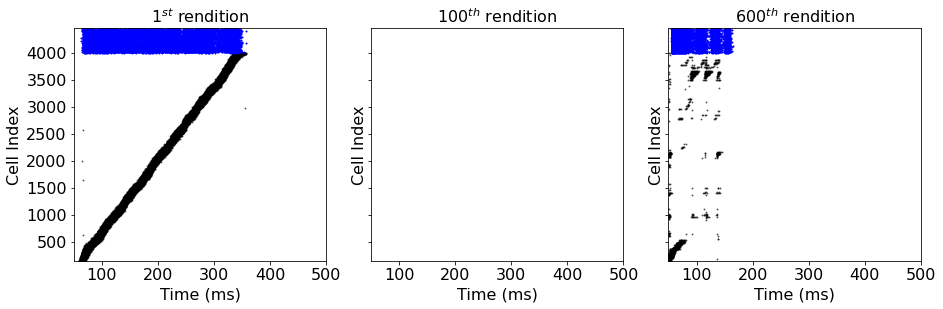

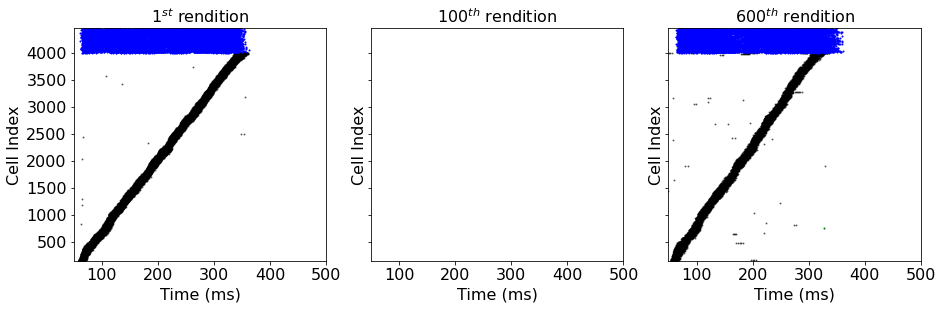

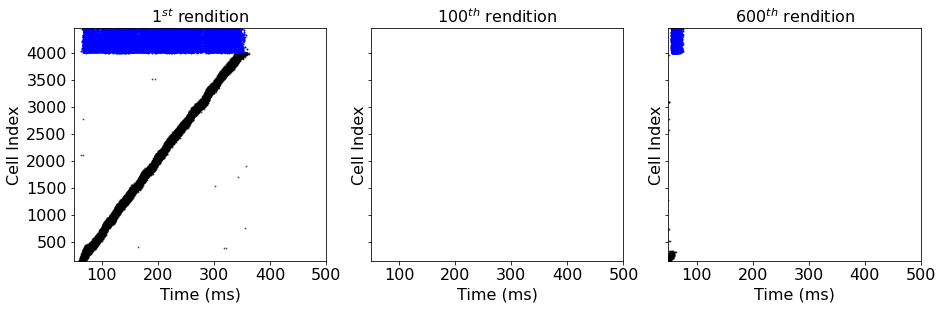

In [16]:
make_figure_1(title_wide_attr_small_inh, timepoints = [0, 10, 60])

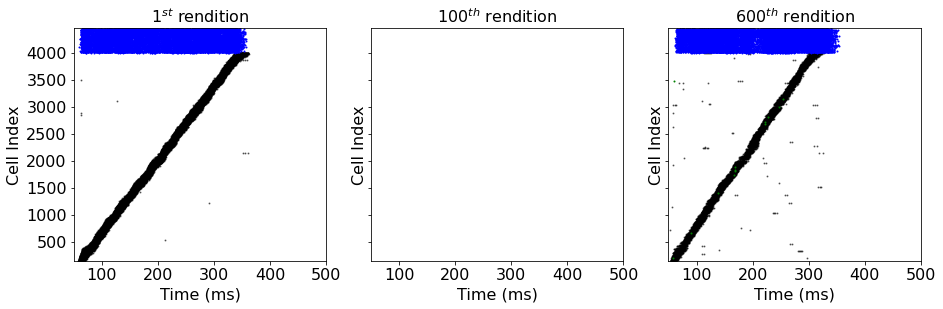

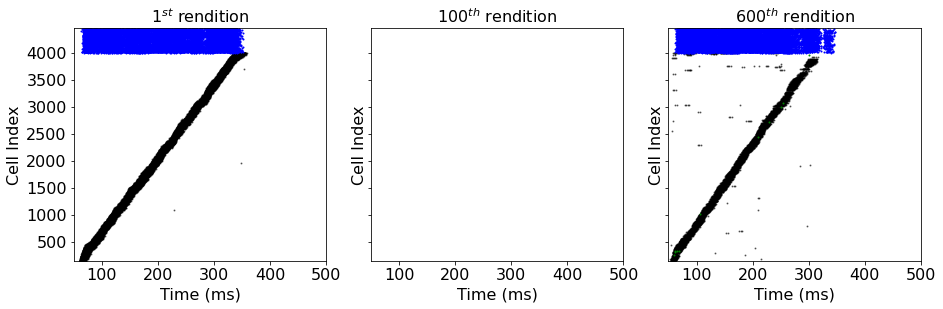

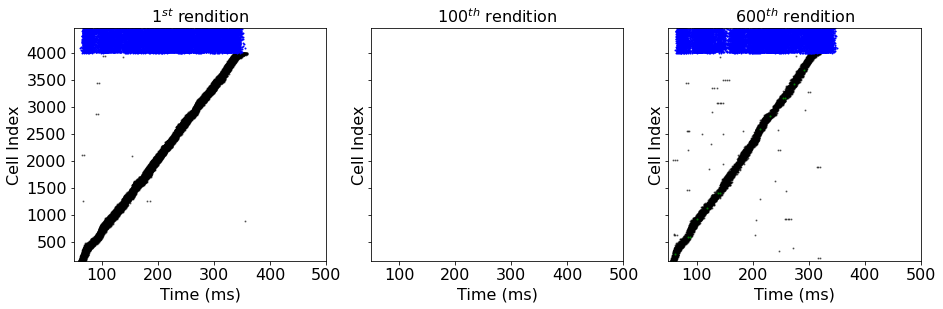

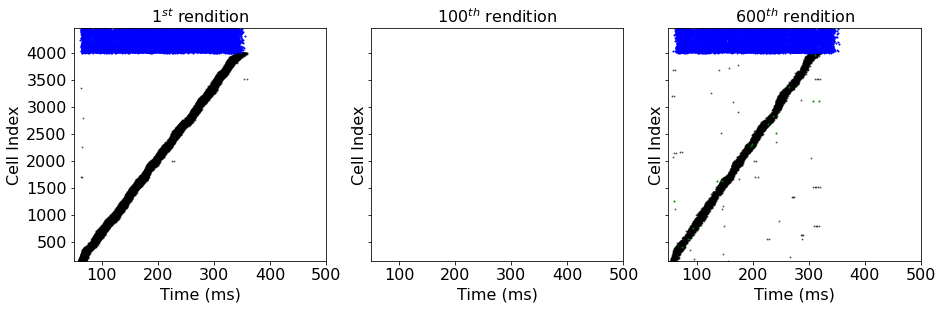

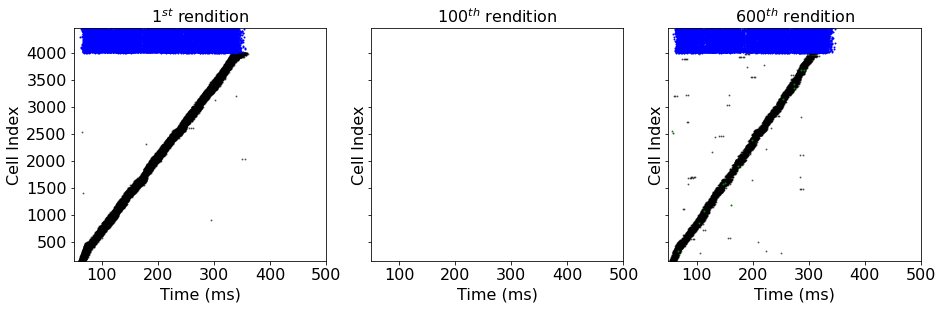

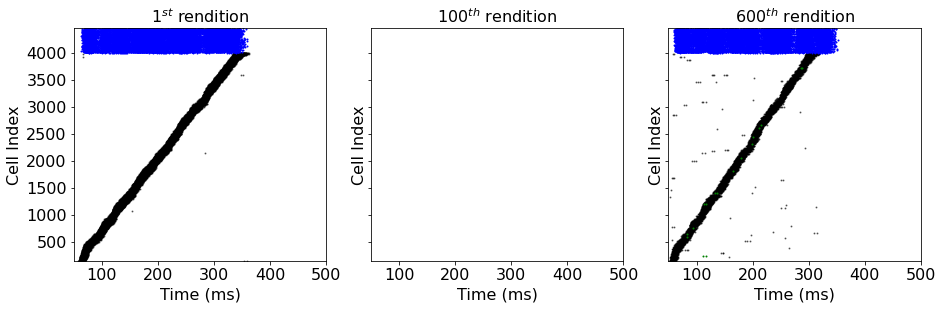

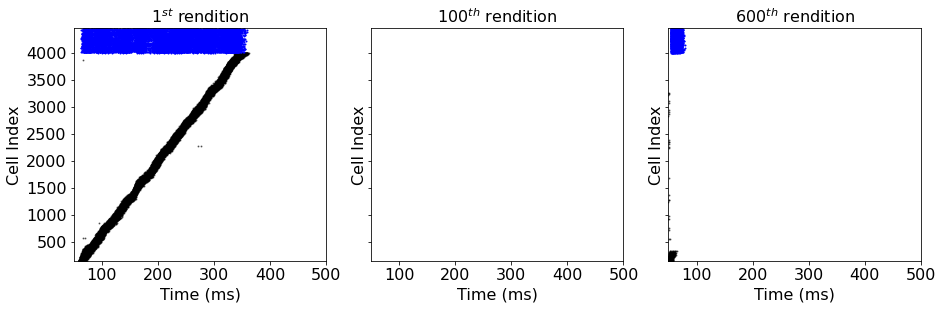

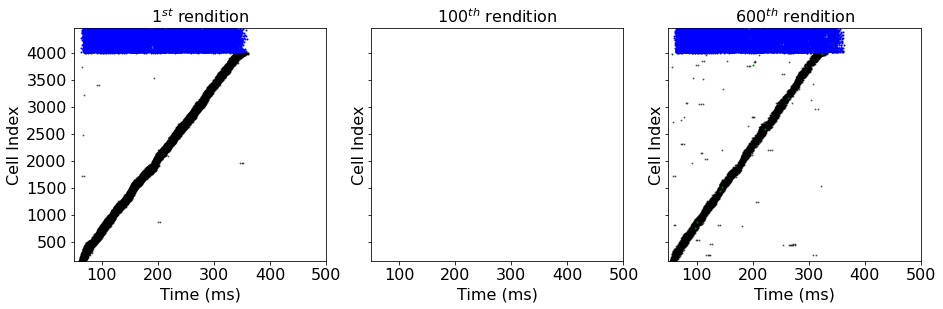

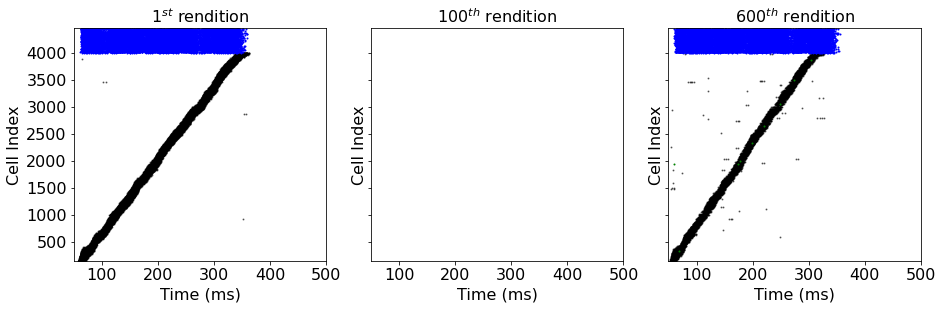

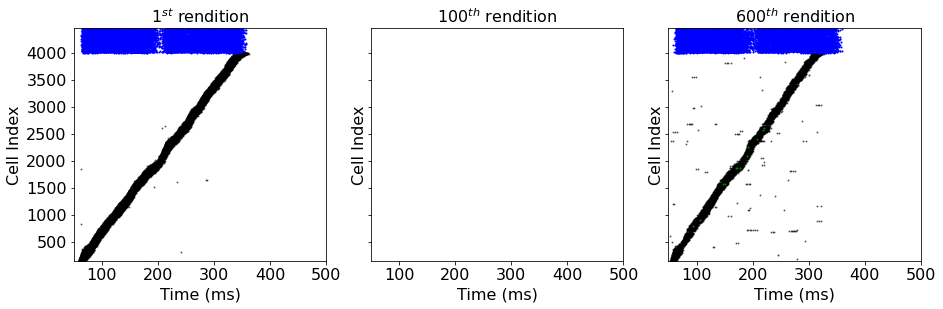

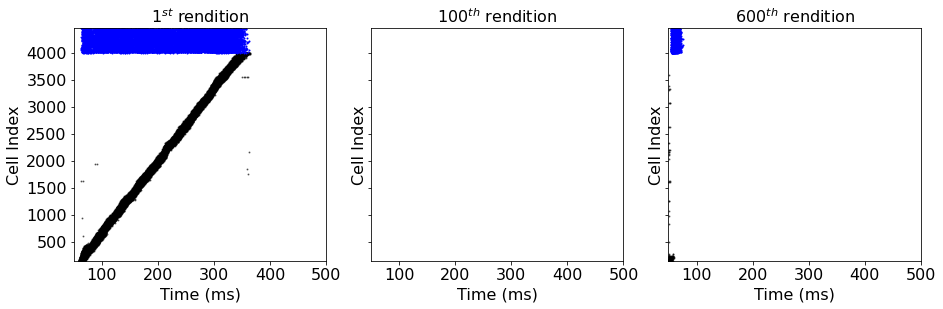

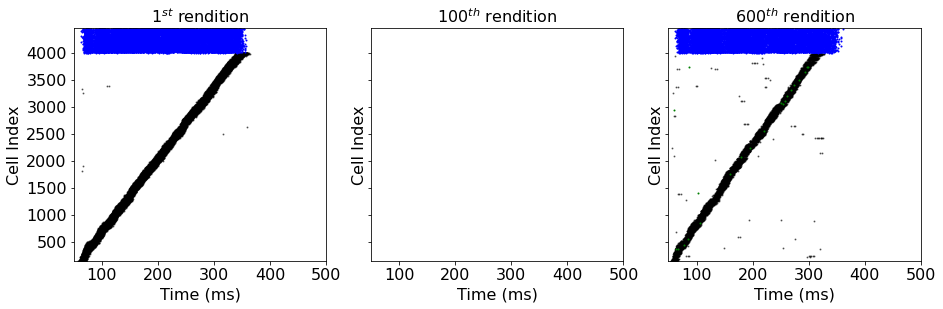

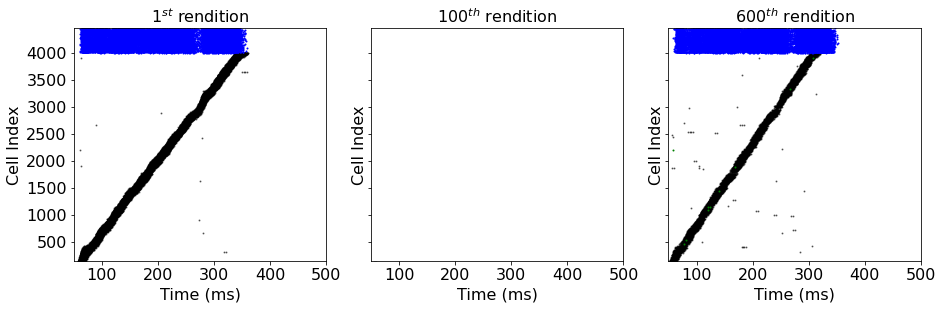

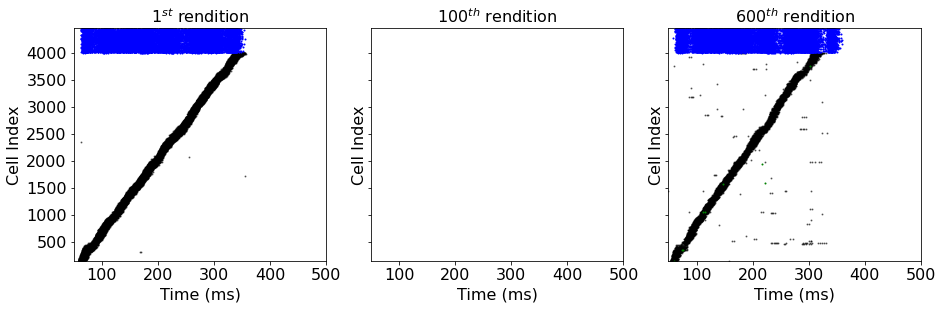

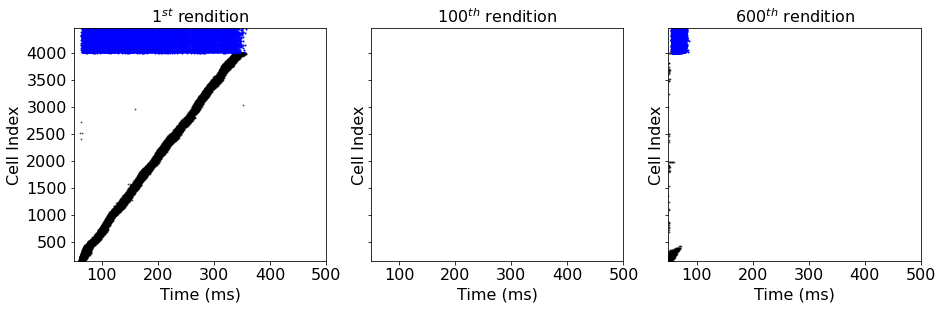

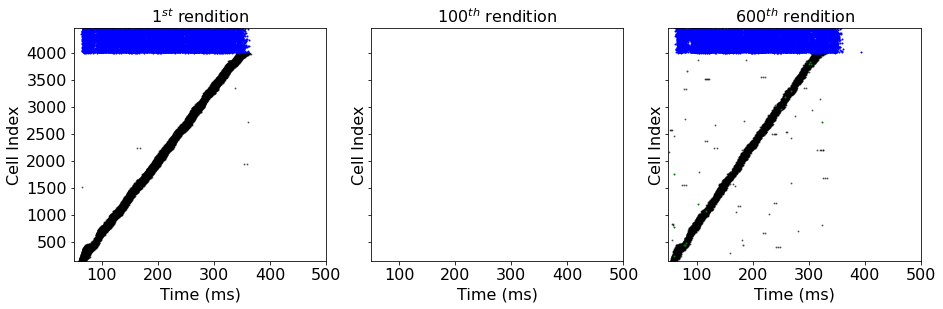

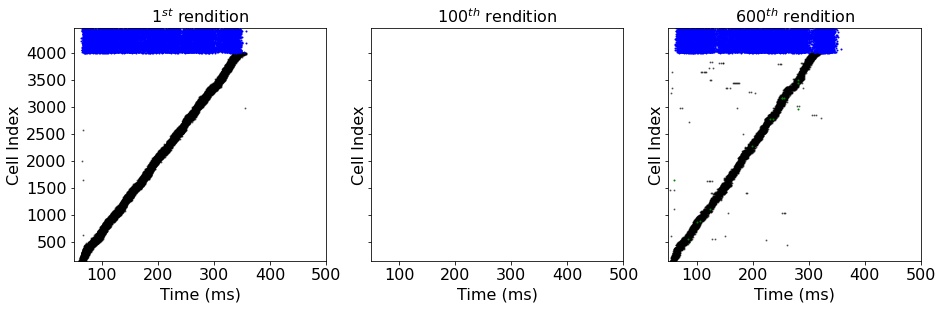

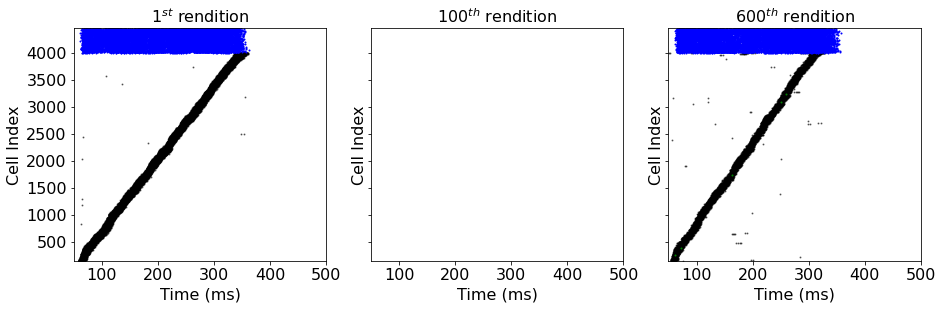

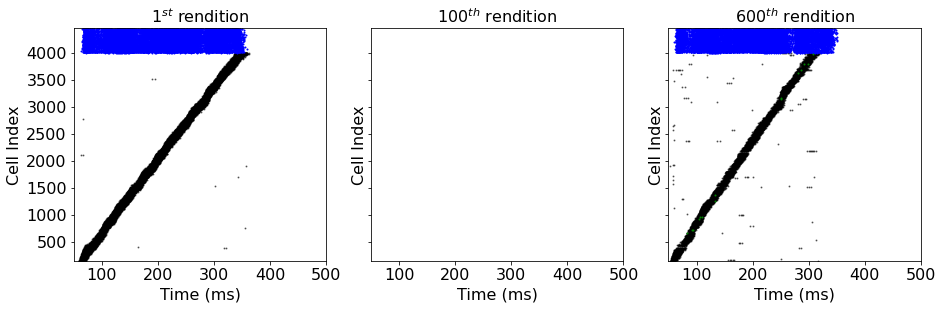

In [17]:
make_figure_1(title_single_small_inh, timepoints = [0, 10, 60])

In [29]:
def determine_recovered(names, timepoints, threshold=0.9):
    verify_chain_timepoints = np.arange(10)
    recovered_dir_names = []
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    all_recovery_pers = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        count_verified = 0
        per_recovered_for_name = 0
        last_layer_actives_for_name = []
        for j, exp_dir_name in enumerate(exp_dir_names):
            timepoints_verified = np.zeros(len(verify_chain_timepoints))
            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i in verify_chain_timepoints:
                    data = load_data()
                    timepoints_verified[i] = int(data['percent_layers_active'] >= 0.9)
            if (np.sum(timepoints_verified) / len(timepoints_verified)) < 1.:
                continue
            count_verified += 1
            n_active = 0
            n_count = 0
            last_layer_actives = []
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                n_active += int(data['percent_layers_active'] >= 0.9)
                n_count += 1
            if n_active == 0:
                continue
            if n_active / n_count >= threshold:
                recovered_dir_names.append(exp_dir_name)
                per_recovered_for_name += 1
        if count_verified != 0:
            per_recovered_for_name /= count_verified
        else:
            per_recovered_for_name = 0.
        all_recovery_pers.append(per_recovered_for_name)
        
    return recovered_dir_names, all_recovery_pers


In [30]:
def iter_range(r, n):
    if n == 1:
        yield (0, r[0])
    else:
        for i in range(n):
            yield (i, i * (r[1] - r[0]) / (n - 1) + r[0])

In [31]:
def real_to_str(real):
    s = f'{real}'
    first_sig_digit_idx = re.search('[1-9]', s)
    if not first_sig_digit_idx:
        return s
    
    x = s.rfind('00')
    while x >= 0 and x > first_sig_digit_idx.start():
        s = s[:x]
        x = s.rfind('00')
    return s

In [32]:
all_name_frags = [
    title_one_sided_large_gamma_small_inh,
    title_one_sided_small_gamma_small_inh,
    title_one_sided_large_gamma_large_inh,
    title_one_sided_small_gamma_large_inh,
    title_pop_single_small_inh,
    title_pop_single_large_inh,
    title_wide_attr_small_inh,
    title_wide_attr_large_inh,
    title_single_small_inh,
    title_single_large_inh,
]
recovered_exp_names, all_recovery_pers = determine_recovered(all_name_frags, np.arange(50, 60))


In [33]:
all_recovery_pers

[1.0,
 1.0,
 1.0,
 0.8421052631578947,
 1.0,
 1.0,
 0.47368421052631576,
 0.47368421052631576,
 0.8421052631578947,
 0.7894736842105263]

In [34]:
def make_figure_2_plot(names, labels, condition_colors, file_name_ext='', ylim1=None, ylim2=None, cap=100, timepoints=[], offsets=[], vertical_spacing=1.):
    
    scale = 1.8
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(6 * scale, 5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
                
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
#             axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color=condition_colors[idx], lw=0.5, zorder=-1)
        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx

        axs[0].fill_between(
            timepoints * 10,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx], alpha=0.2)
        axs[0].plot(timepoints * 10, e_e_means + y_disp, lw=1.5, color=condition_colors[idx], label=labels[idx])
        axs[1].fill_between(
            timepoints * 10,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx], alpha=0.2)
        axs[1].plot(timepoints * 10, e_i_means + y_disp, lw=1.5, color=condition_colors[idx], label=labels[idx])

        axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(0, (cap - 1) * 10)
            axs[i].set_xlabel('Rendition number')
            axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 16)
        
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
            
        axs[0].legend(loc='upper right')
        fig.tight_layout()
        save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

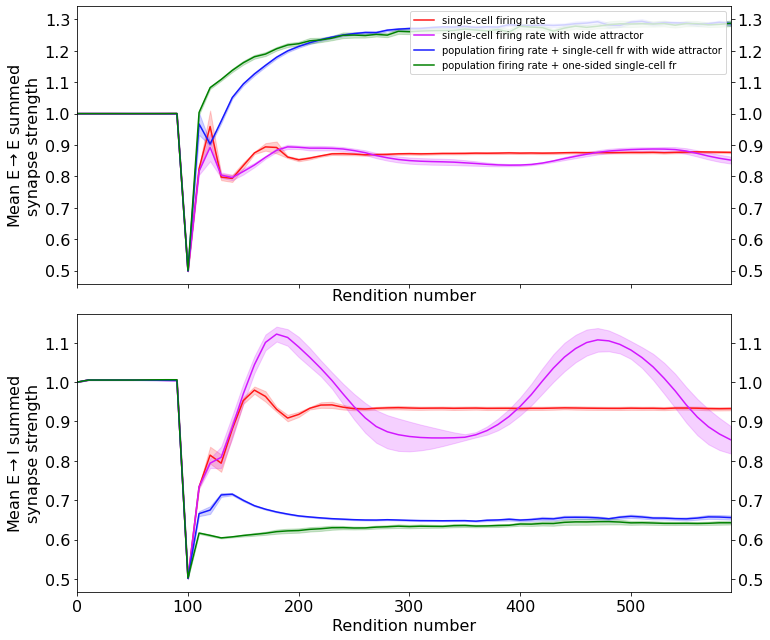

In [35]:
timepoints = np.arange(0, 60)

make_figure_2_plot([
    title_single_small_inh,
    title_wide_attr_small_inh,
    title_pop_single_small_inh,
    title_one_sided_large_gamma_small_inh,
], labels=[
    'single-cell firing rate',
    'single-cell firing rate with wide attractor',
    'population firing rate + single-cell fr with wide attractor',
    'population firing rate + one-sided single-cell fr'
], condition_colors=['#ff1717', '#d117ff', '#171bff', 'green'], timepoints=timepoints, cap=60,
    offsets=[0, 0, 0, 0], vertical_spacing=0., file_name_ext='all_3_silent')

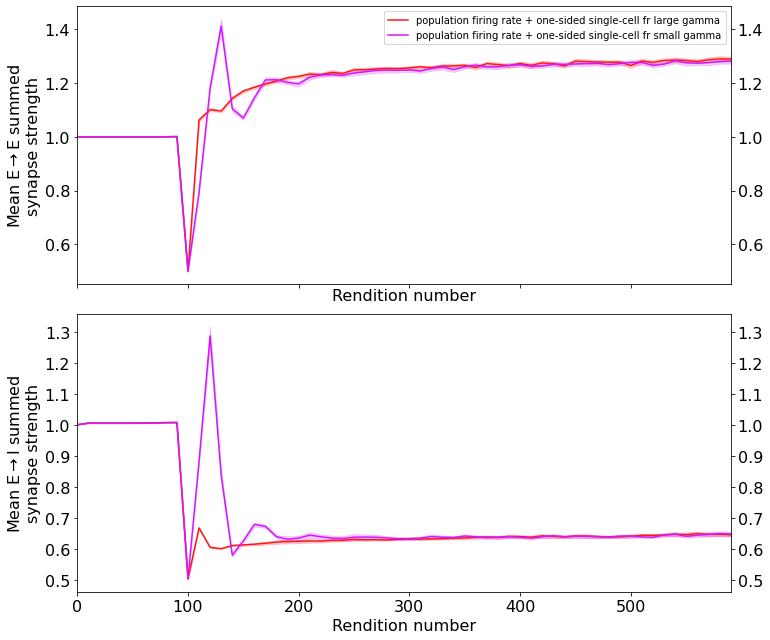

In [36]:
timepoints = np.arange(0, 60)

make_figure_2_plot([
    title_one_sided_large_gamma_large_inh,
    title_one_sided_small_gamma_large_inh,
], labels=[
    'population firing rate + one-sided single-cell fr large gamma',
    'population firing rate + one-sided single-cell fr small gamma'
], condition_colors=['#ff1717', '#d117ff', '#171bff', 'green'], timepoints=timepoints, cap=60,
    offsets=[0, 0], vertical_spacing=0., file_name_ext='all_3_silent')

In [26]:
def extract_final_weight_stats(names, recovered_dir_names, timepoints):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    means_e_e = []
    means_e_i = []
    summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        all_mean_incoming_summed_weights = []
        all_mean_incoming_summed_weights_e_i = []
        all_summed_incoming_weights = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_dir_names:
                continue
            if j == 0:
                print(exp_dir_name)
            
            mean_incoming_summed_weights_for_tps = []
            std_incoming_summed_weights_for_tps = []
            mean_incoming_summed_weights_e_i_for_tps = []
            std_incoming_summed_weights_e_i_for_tps = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None
            
            summed_incoming_weights = []
            
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                if i == 0 or i == timepoints[-1]:
                    summed_incoming_weights.append(data['summed_incoming_weights'])
                
                if i == 0:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                else:
                    mean_incoming_summed_weights_for_tps.append(data['mean_incoming_summed_weights'])
                    std_incoming_summed_weights_for_tps.append(data['std_incoming_summed_weights'])
                    mean_incoming_summed_weights_e_i_for_tps.append(data['mean_incoming_summed_weights_e_i'])
                    std_incoming_summed_weights_e_i_for_tps.append(data['std_incoming_summed_weights_e_i'])
            
            all_mean_incoming_summed_weights.append(np.nanmean(mean_incoming_summed_weights_for_tps) / baseline_mean)
            all_mean_incoming_summed_weights_e_i.append(np.nanmean(mean_incoming_summed_weights_e_i_for_tps) / baseline_mean_e_i)
            all_summed_incoming_weights.append(summed_incoming_weights)
        
        means_e_e.append(np.nanmean(all_mean_incoming_summed_weights))
        means_e_i.append(np.nanmean(all_mean_incoming_summed_weights_e_i))
        summed_weights.append(all_summed_incoming_weights)
        
        
    return means_e_e, means_e_i, summed_weights

single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2079_ALPHA_2_0.005_ALPHA_1_0.03_ff_1.0_eir_1.0_ier_0.3_2021-11-12--00:42--35:3447
single_silent_only_wide_attr__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_ff_1.0_eir_1.0_ier_0.3_2021-11-12--00:40--17:1801
pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2074_ALPHA_2_0.005_ALPHA_1_0.03_GAMMA_1e-05_ff_1.0_eir_1.0_ier_0.3_2021-11-12--00:39--47:7994
pop_single_one_sided__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2079_ALPHA_2_0.005_ALPHA_1_0.03_GAMMA_3e-05_ff_1.0_eir_1.0_ier_0.3_2021-11-12--00:41--53:3447
pop_single_one_sided__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2068_ALPHA_2_0.005_ALPHA_1_0.03_GAMMA_1e-05_ff_1.0_eir_1.0_ier_0.3_2021-11-12--00:41--23:7863


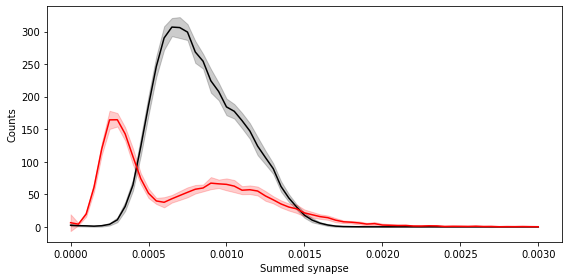

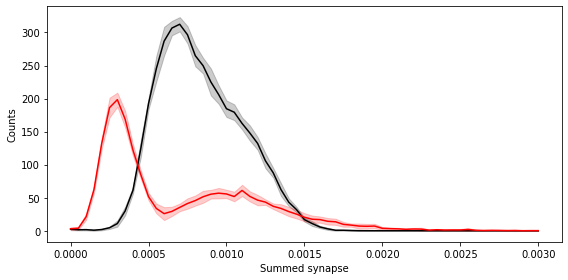

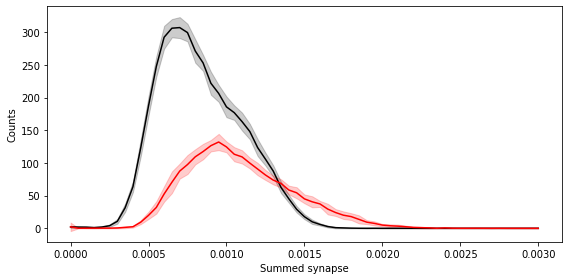

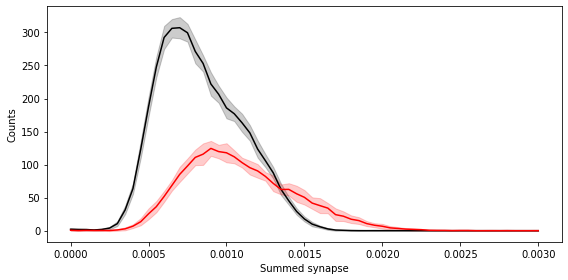

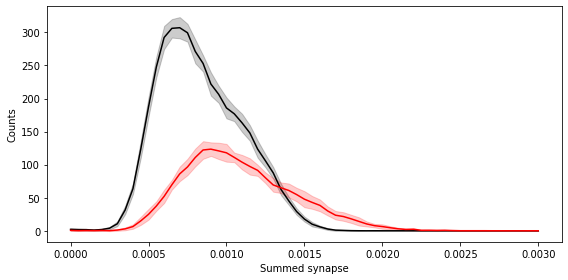

In [37]:
all_name_frags = [
    title_single_small_inh,
    title_wide_attr_small_inh,
    title_pop_single_small_inh,
    title_one_sided_large_gamma_small_inh,
    title_one_sided_small_gamma_small_inh,
]

for name_frags in all_name_frags:
    means_e_e, means_e_i, summed_weights = extract_final_weight_stats([name_frags], recovered_exp_names, [0] + [x for x in range(50, 60)])
    aggregate_weight_dist_data = []

    for i in range(len(summed_weights)):
        initial_weight_dists = []
        final_weight_dists = []
        if len(summed_weights[i]) == 0:
            aggregate_weight_dist_data.append({})
        else:
            for j in range(len(summed_weights[i])):
                initial_weight_dists.append(bin_occurrences(summed_weights[i][j][0], max_val=0.003, bin_size=0.00005))
                final_weight_dists.append(bin_occurrences(summed_weights[i][j][1], max_val=0.003, bin_size=0.00005))

            stacked_initial = np.stack([t[1] for t in initial_weight_dists])
            stacked_final = np.stack([t[1] for t in final_weight_dists])

            mean_weight_dists_initial = np.nanmean(stacked_initial, axis=0)
            mean_weight_dists_final = np.nanmean(stacked_final, axis=0)
            std_weight_dists_initial = np.nanstd(stacked_initial, axis=0)
            std_weight_dists_final = np.nanstd(stacked_final, axis=0)

            aggregate_weight_dist_data.append({
                'mean_weight_dists_initial': mean_weight_dists_initial,
                'mean_weight_dists_final': mean_weight_dists_final,
                'std_weight_dists_initial': std_weight_dists_initial,
                'std_weight_dists_final': std_weight_dists_final,
                'summed_weight_bins': initial_weight_dists[0][0],
            }) 
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 4))

    for i, dist_data in enumerate(aggregate_weight_dist_data):
        if bool(dist_data):
            axs.fill_between(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_initial'] - dist_data['std_weight_dists_initial'], dist_data['mean_weight_dists_initial'] + dist_data['std_weight_dists_initial'], color='black', alpha=0.2)
            axs.plot(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_initial'], color='black')
            axs.fill_between(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_final'] - dist_data['std_weight_dists_final'], dist_data['mean_weight_dists_final'] + dist_data['std_weight_dists_final'], color='red', alpha=0.2)
            axs.plot(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_final'], color='red')
            axs.set_ylabel('Counts')
            axs.set_xlabel('Summed synapse')
    fig.tight_layout()
        